               1990          2000          2010          2020
count  1.200000e+01  1.200000e+01  1.200000e+01  1.200000e+01
mean   9.497644e+07  1.217992e+08  1.545429e+08  1.873110e+08
std    9.397107e+07  1.361786e+08  1.932029e+08  2.535542e+08
min    5.629035e+06  8.638858e+06  1.296971e+07  1.845514e+07
25%    2.699465e+07  3.363265e+07  4.023042e+07  4.979199e+07
50%    5.140655e+07  5.397470e+07  5.698537e+07  6.034688e+07
75%    1.305454e+08  1.628638e+08  1.866585e+08  2.077375e+08
max    3.001656e+08  4.529991e+08  6.584987e+08  8.668105e+08
Country Name    0
1990            0
2000            0
2010            0
2020            0
dtype: int64
Country Name       Brazil      Canada        China     Germany      France  \
count                 4.0         4.0          4.0         4.0         4.0   
unique                4.0         4.0          4.0         4.0         4.0   
top           111405219.0  21206427.0  300165618.0  58079842.0  42985584.0   
freq                  1.0  

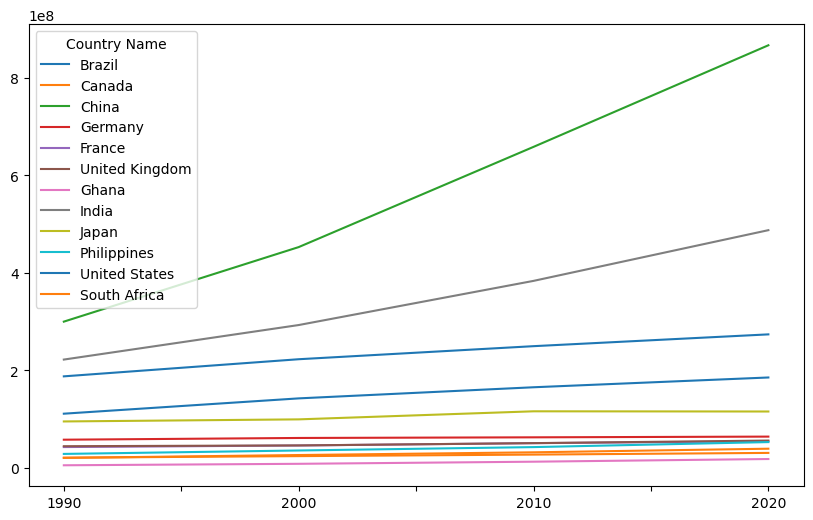

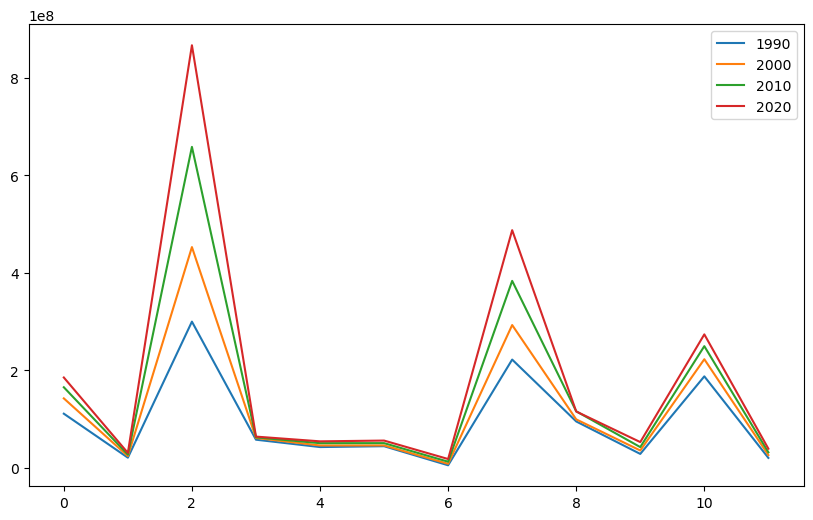

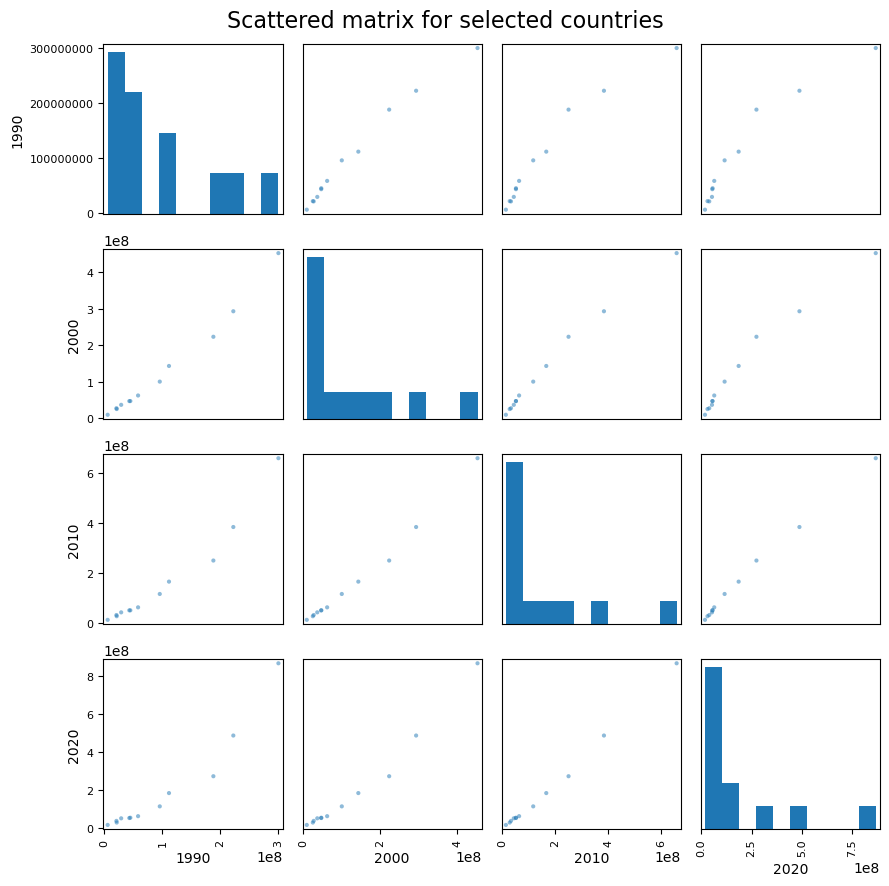

           1990         2020
0   111405219.0  185636418.0
1    21206427.0   30999405.0
2   300165618.0  866810508.0
3    58079842.0   64410589.0
4    42985584.0   54715704.0
5    44733264.0   56283168.0
6     5629035.0   18455138.0
7   222374415.0  487702168.0
8    95496650.0  115884871.0
9    28924064.0   53187498.0
10  187966119.0  274040676.0
11   20751091.0   39605450.0


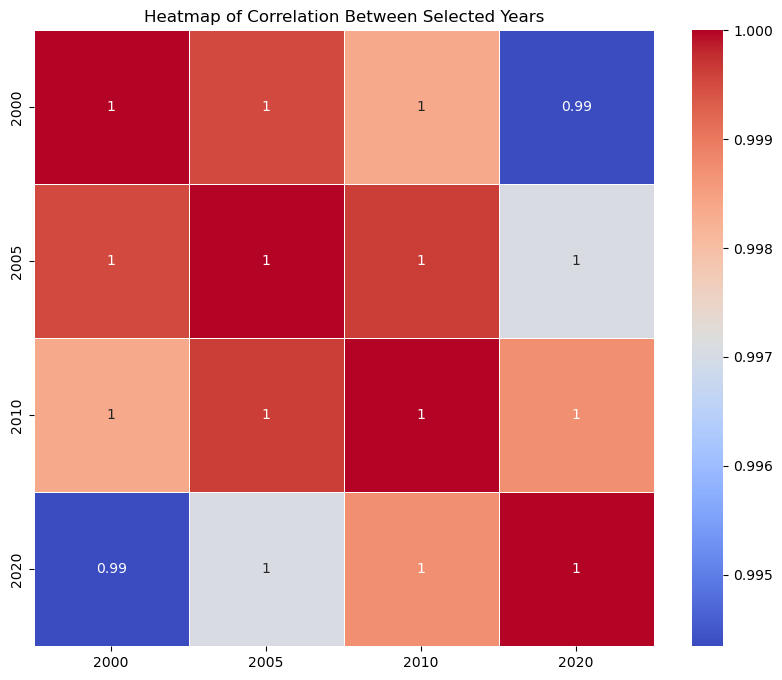

           1990         2020
0   111405219.0  185636418.0
1    21206427.0   30999405.0
2   300165618.0  866810508.0
3    58079842.0   64410589.0
4    42985584.0   54715704.0
5    44733264.0   56283168.0
6     5629035.0   18455138.0
7   222374415.0  487702168.0
8    95496650.0  115884871.0
9    28924064.0   53187498.0
10  187966119.0  274040676.0
11   20751091.0   39605450.0
            1990          2020
count  12.000000  1.200000e+01
mean    0.000000 -7.401487e-17
std     1.044466  1.044466e+00
min    -0.993075 -6.955679e-01
25%    -0.755601 -5.664820e-01
50%    -0.484269 -5.230033e-01
75%     0.395341  8.414297e-02
max     2.280629  2.799063e+00
Number of clusters: 2, Silhouette Score: 0.7280561904182777
Number of clusters: 3, Silhouette Score: 0.6304084292627345
Number of clusters: 4, Silhouette Score: 0.5571825181702157
Number of clusters: 5, Silhouette Score: 0.49795857520486814
Number of clusters: 6, Silhouette Score: 0.35855953611834696
Number of clusters: 7, Silhouette Score: 0

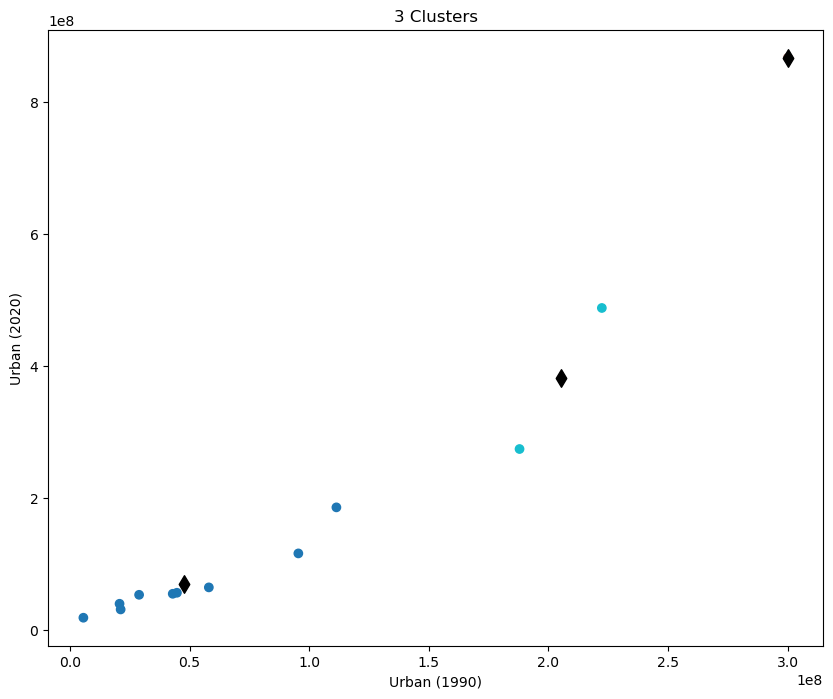

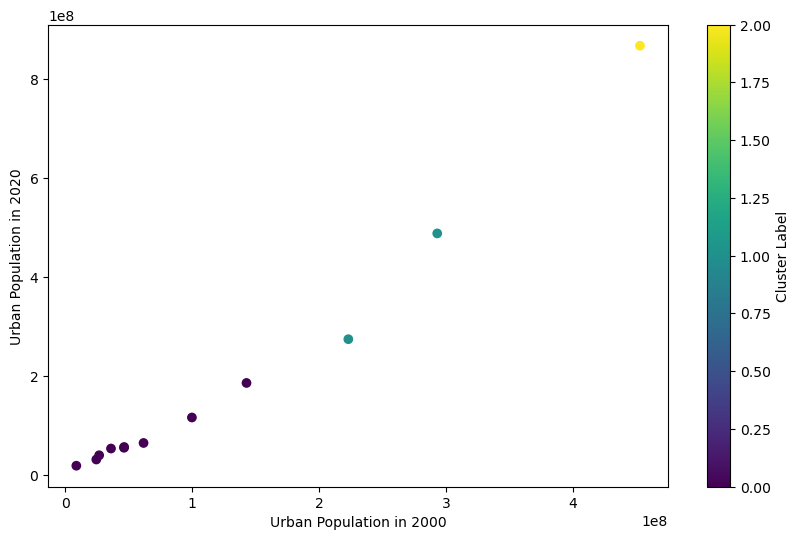

                       0           1            2           3           4   \
Country Name       Brazil      Canada        China     Germany      France   
1960           33724155.0  12368380.0  108085352.0  51978188.0  28866975.0   
1961           35497006.0  12729040.0  110327936.0  52609561.0  29526489.0   
1962           37324448.0  13121753.0  114685540.0  53122383.0  30271423.0   
1963           39220956.0  13522659.0  121162226.0  53664331.0  31179854.0   
...                   ...         ...          ...         ...         ...   
2018          181939117.0  30175056.0  829760595.0  64096118.0  54024861.0   
2019          183878366.0  30638234.0  848982855.0  64294010.0  54388182.0   
2020          185636418.0  30999405.0  866810508.0  64410589.0  54715704.0   
2021          187143228.0  31213082.0  882894483.0  64513567.0  55053076.0   
2022          188517733.0  31825973.0  897578430.0  65067459.0  55402736.0   

                          5           6            7           

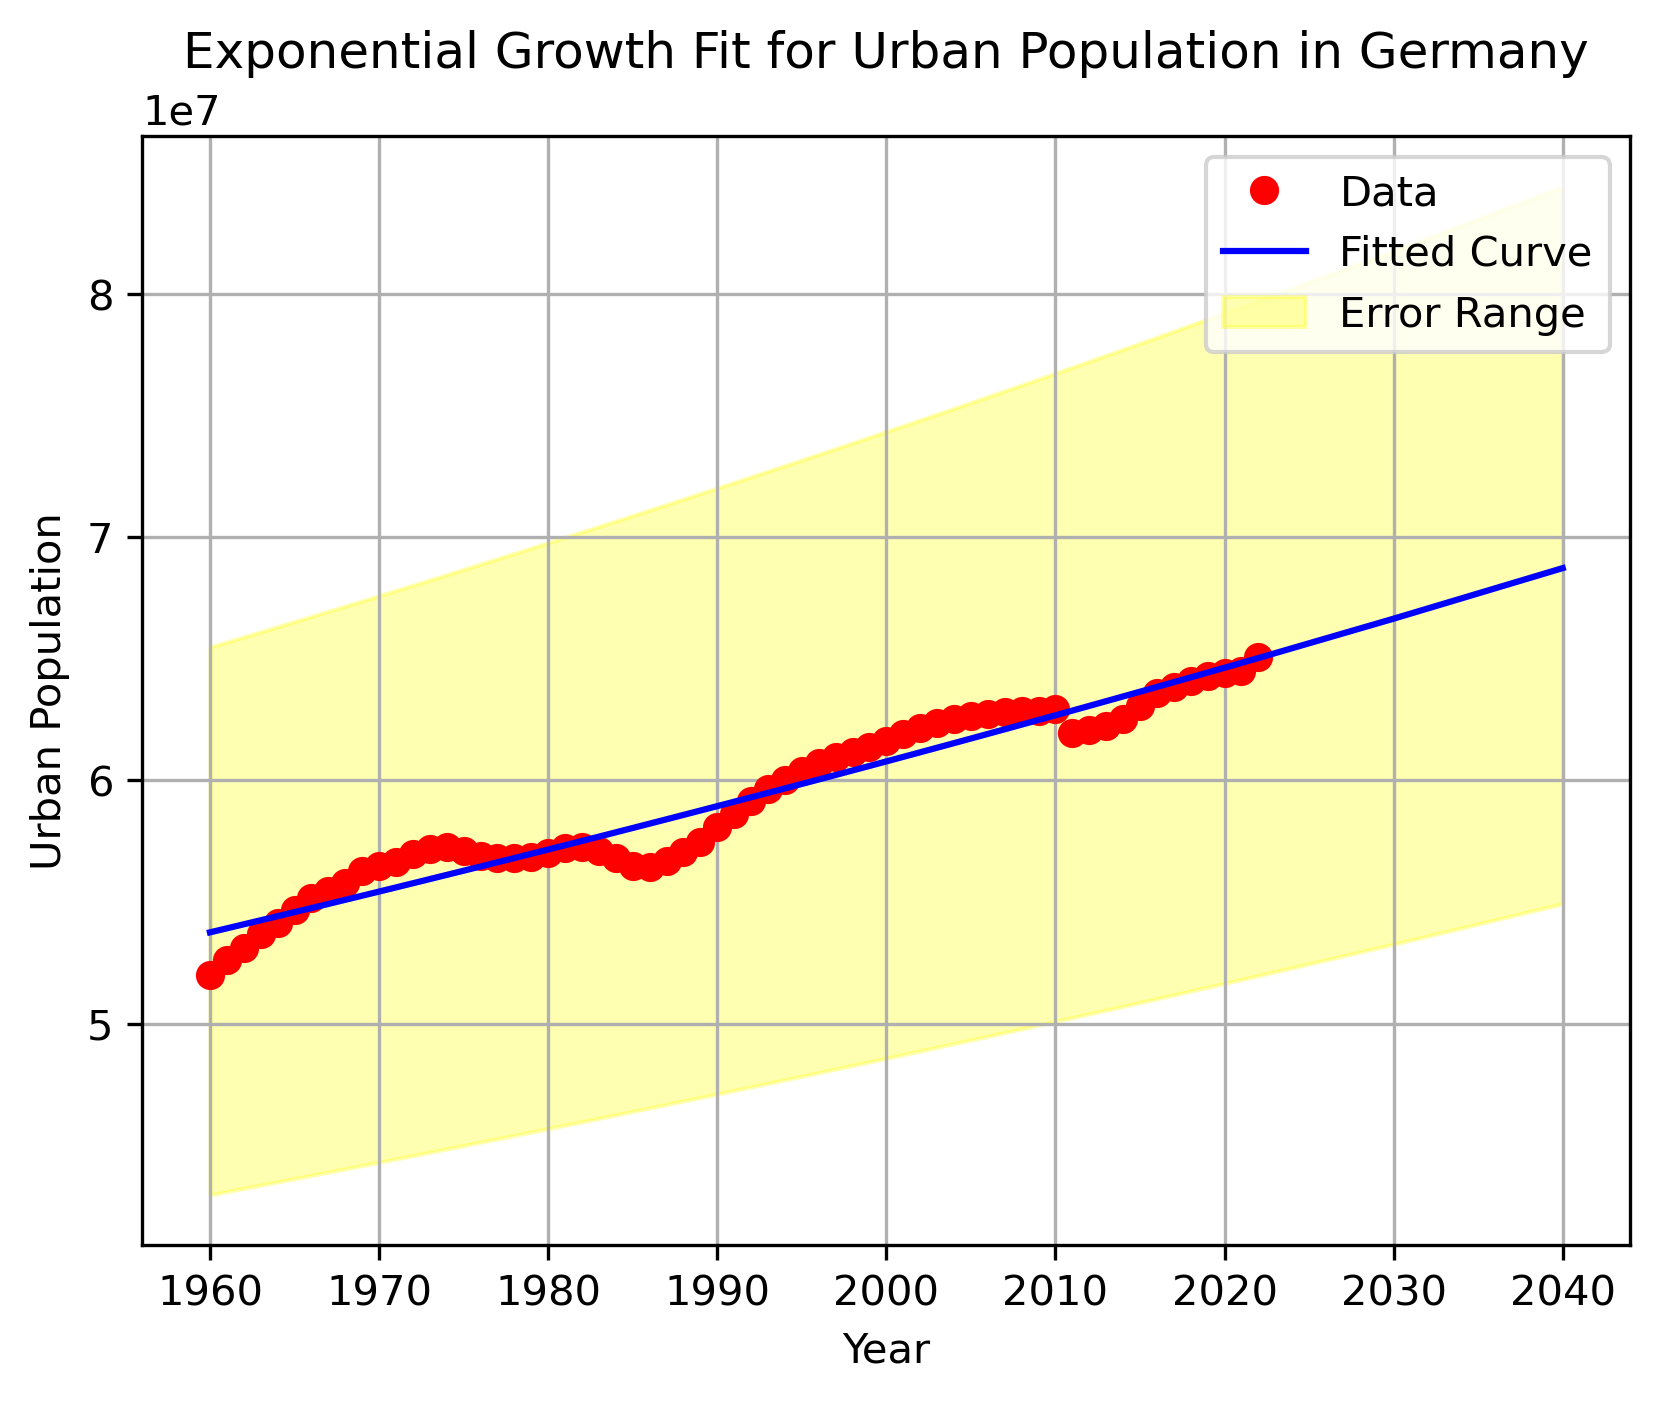

Urban population prediction for 2030: 1286275607.0893712
Urban population prediction for 2040: 1839020288.4419317


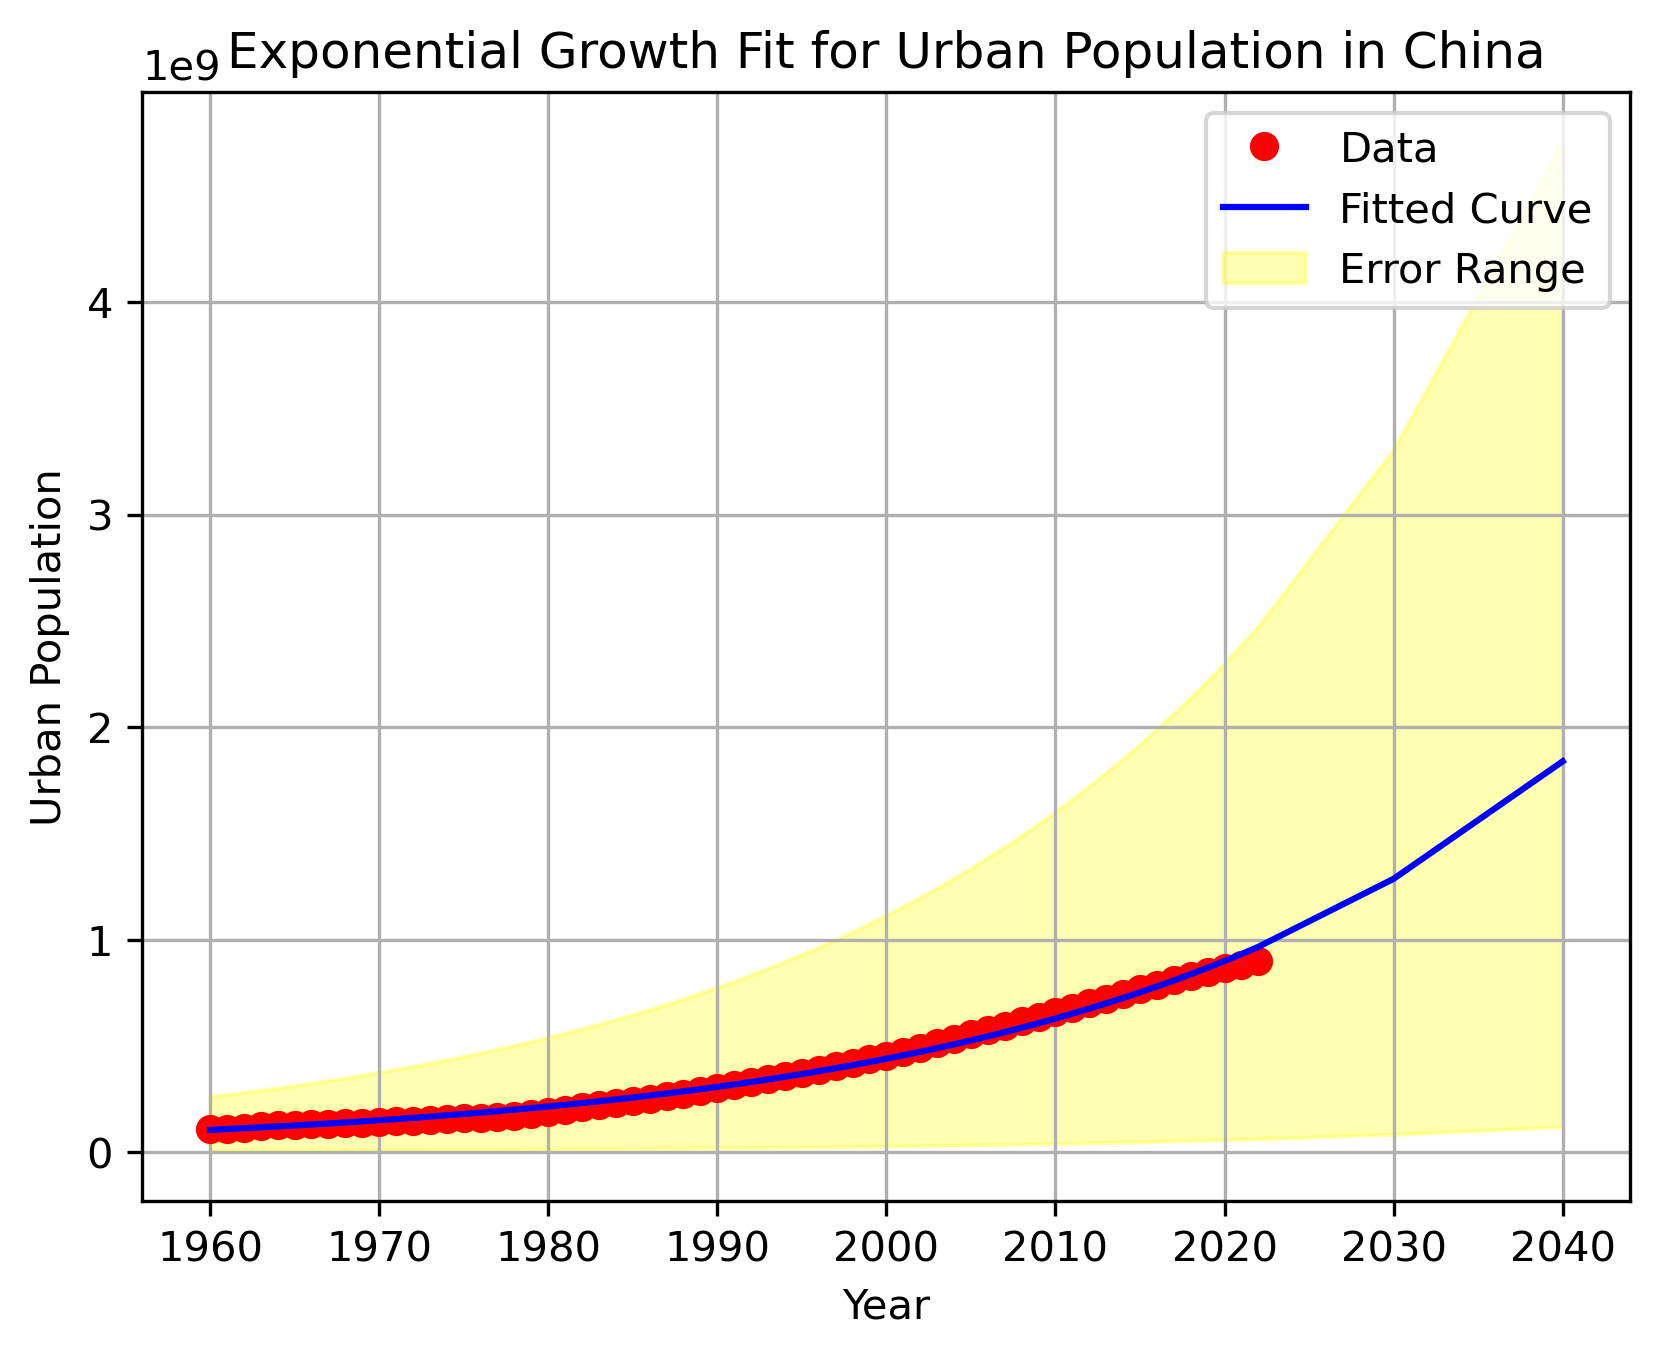

Urban population prediction for 2030: 56274904.318019666
Urban population prediction for 2040: 59103387.53001915


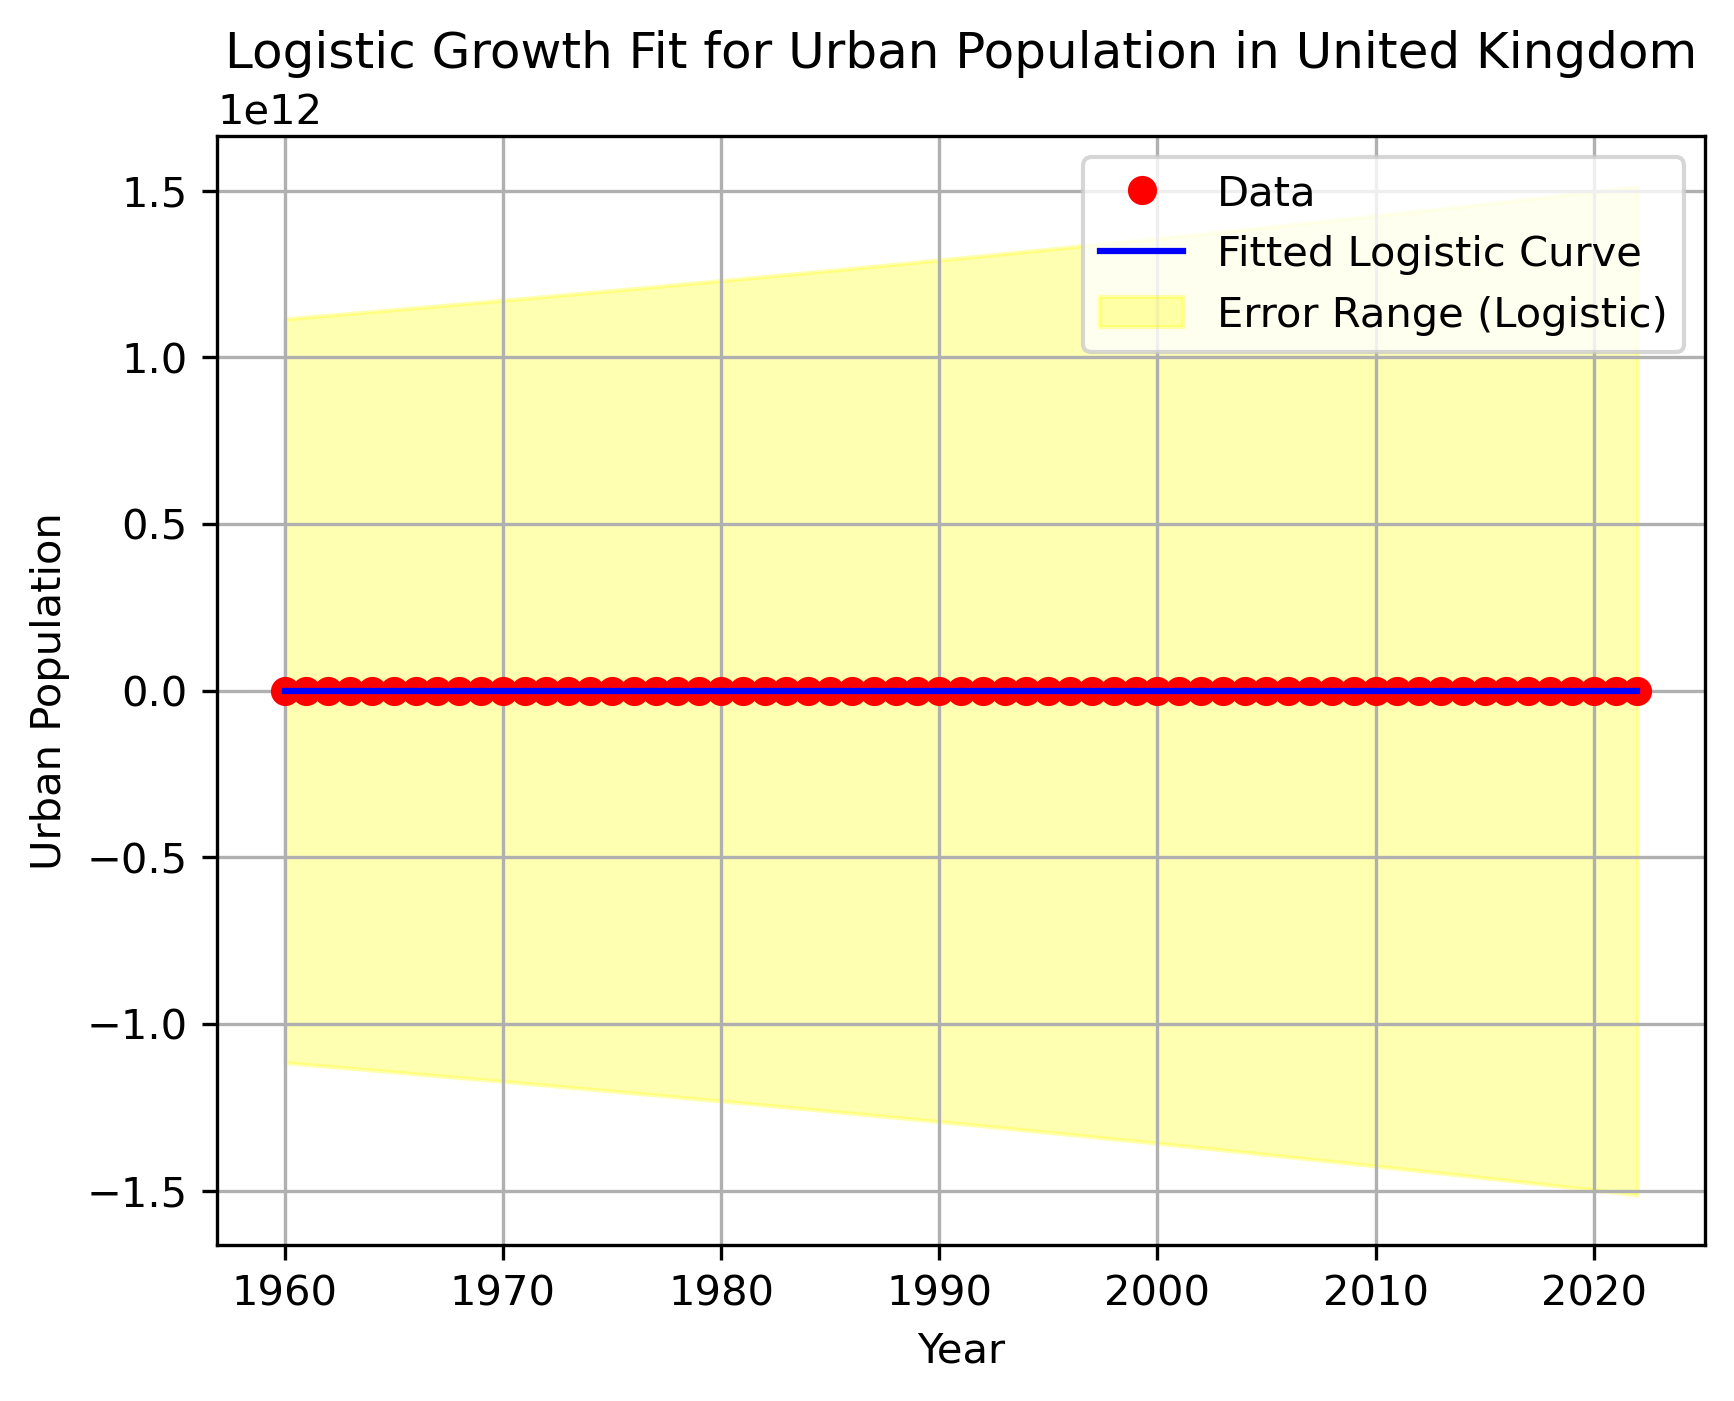

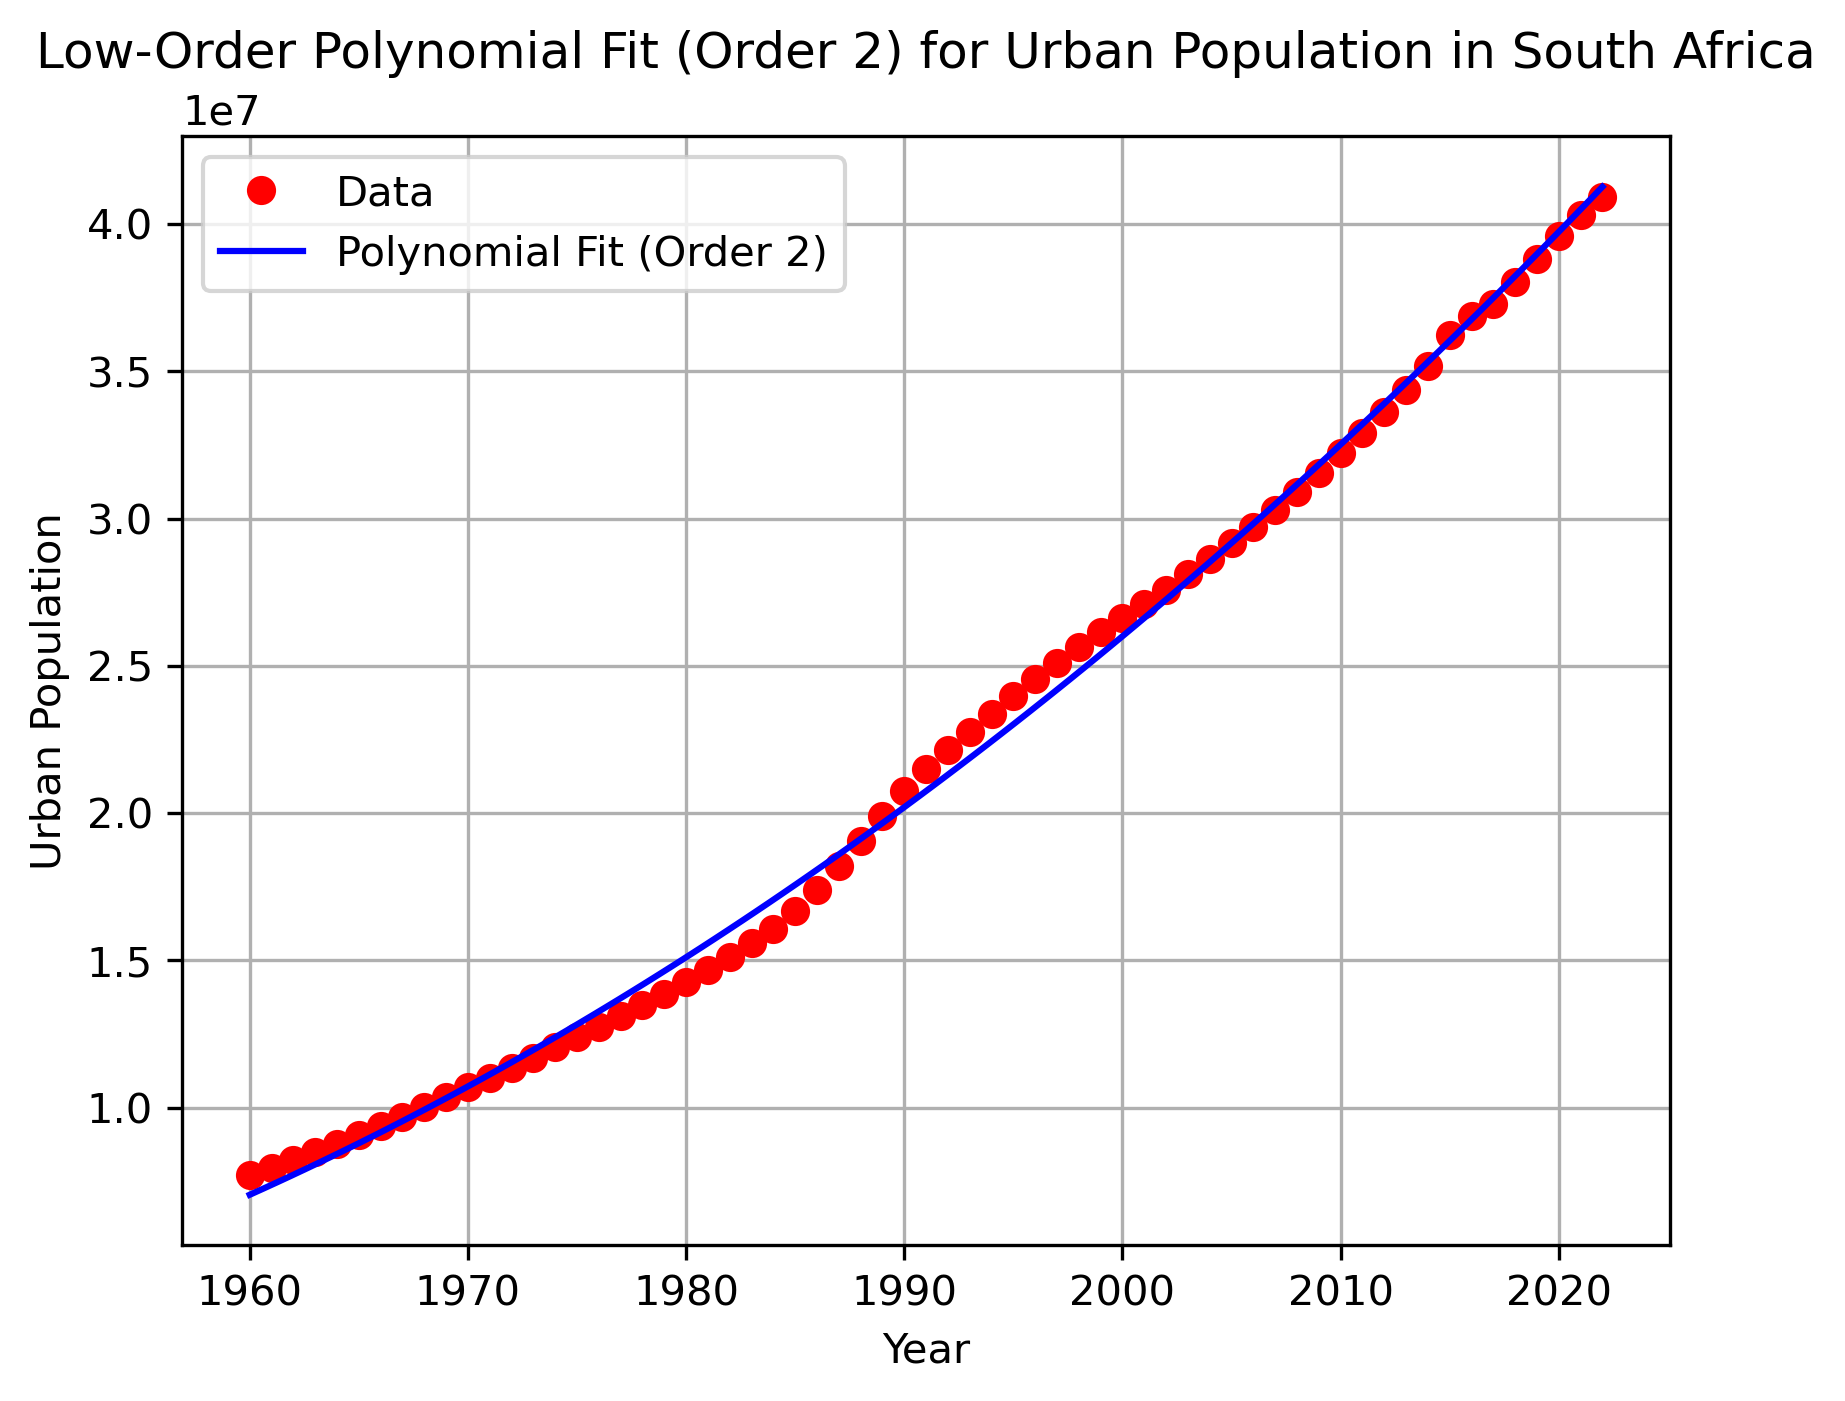

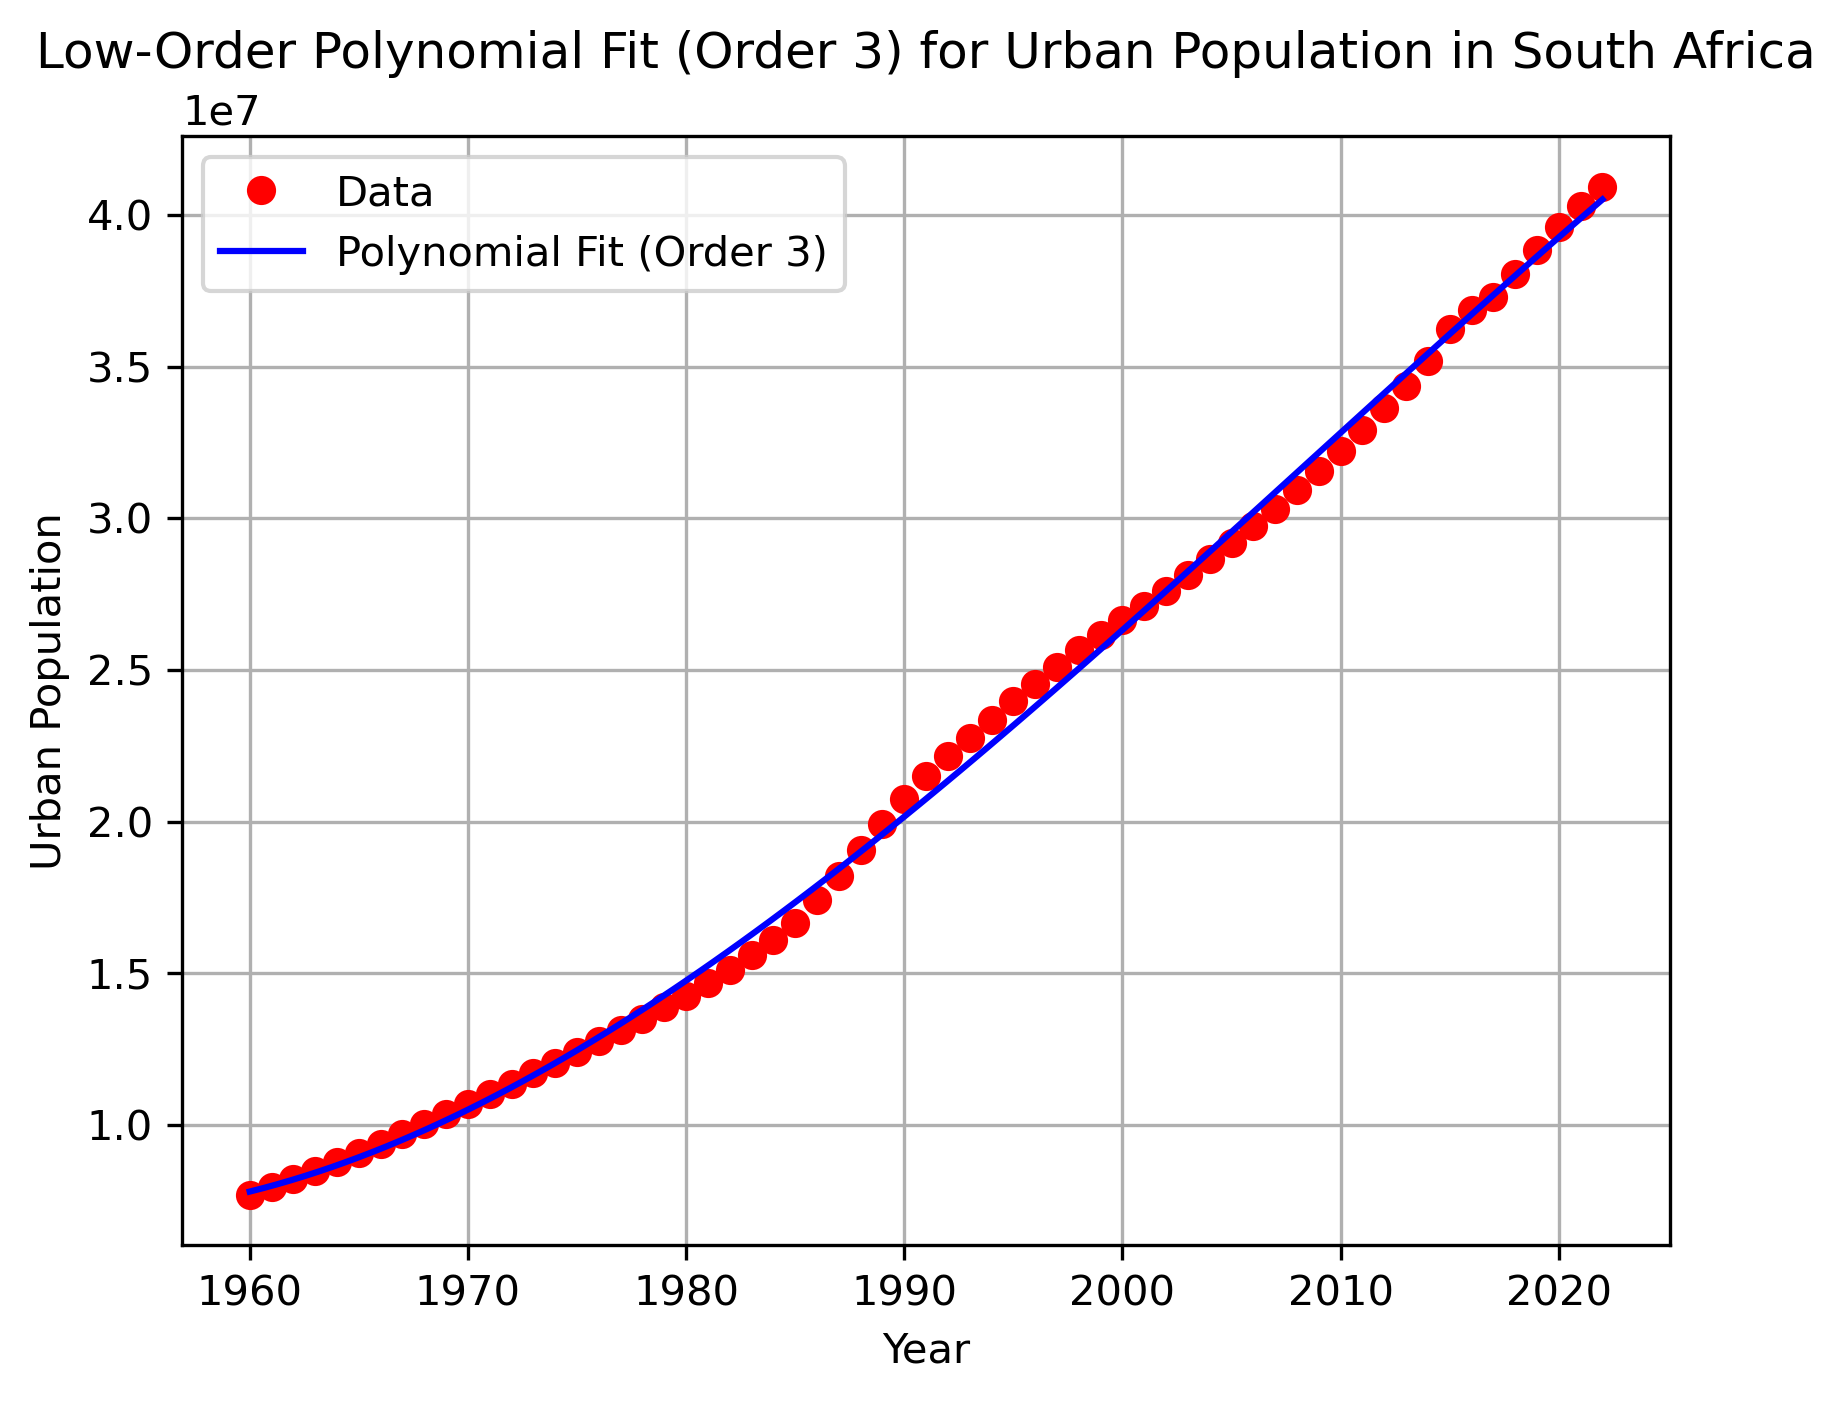

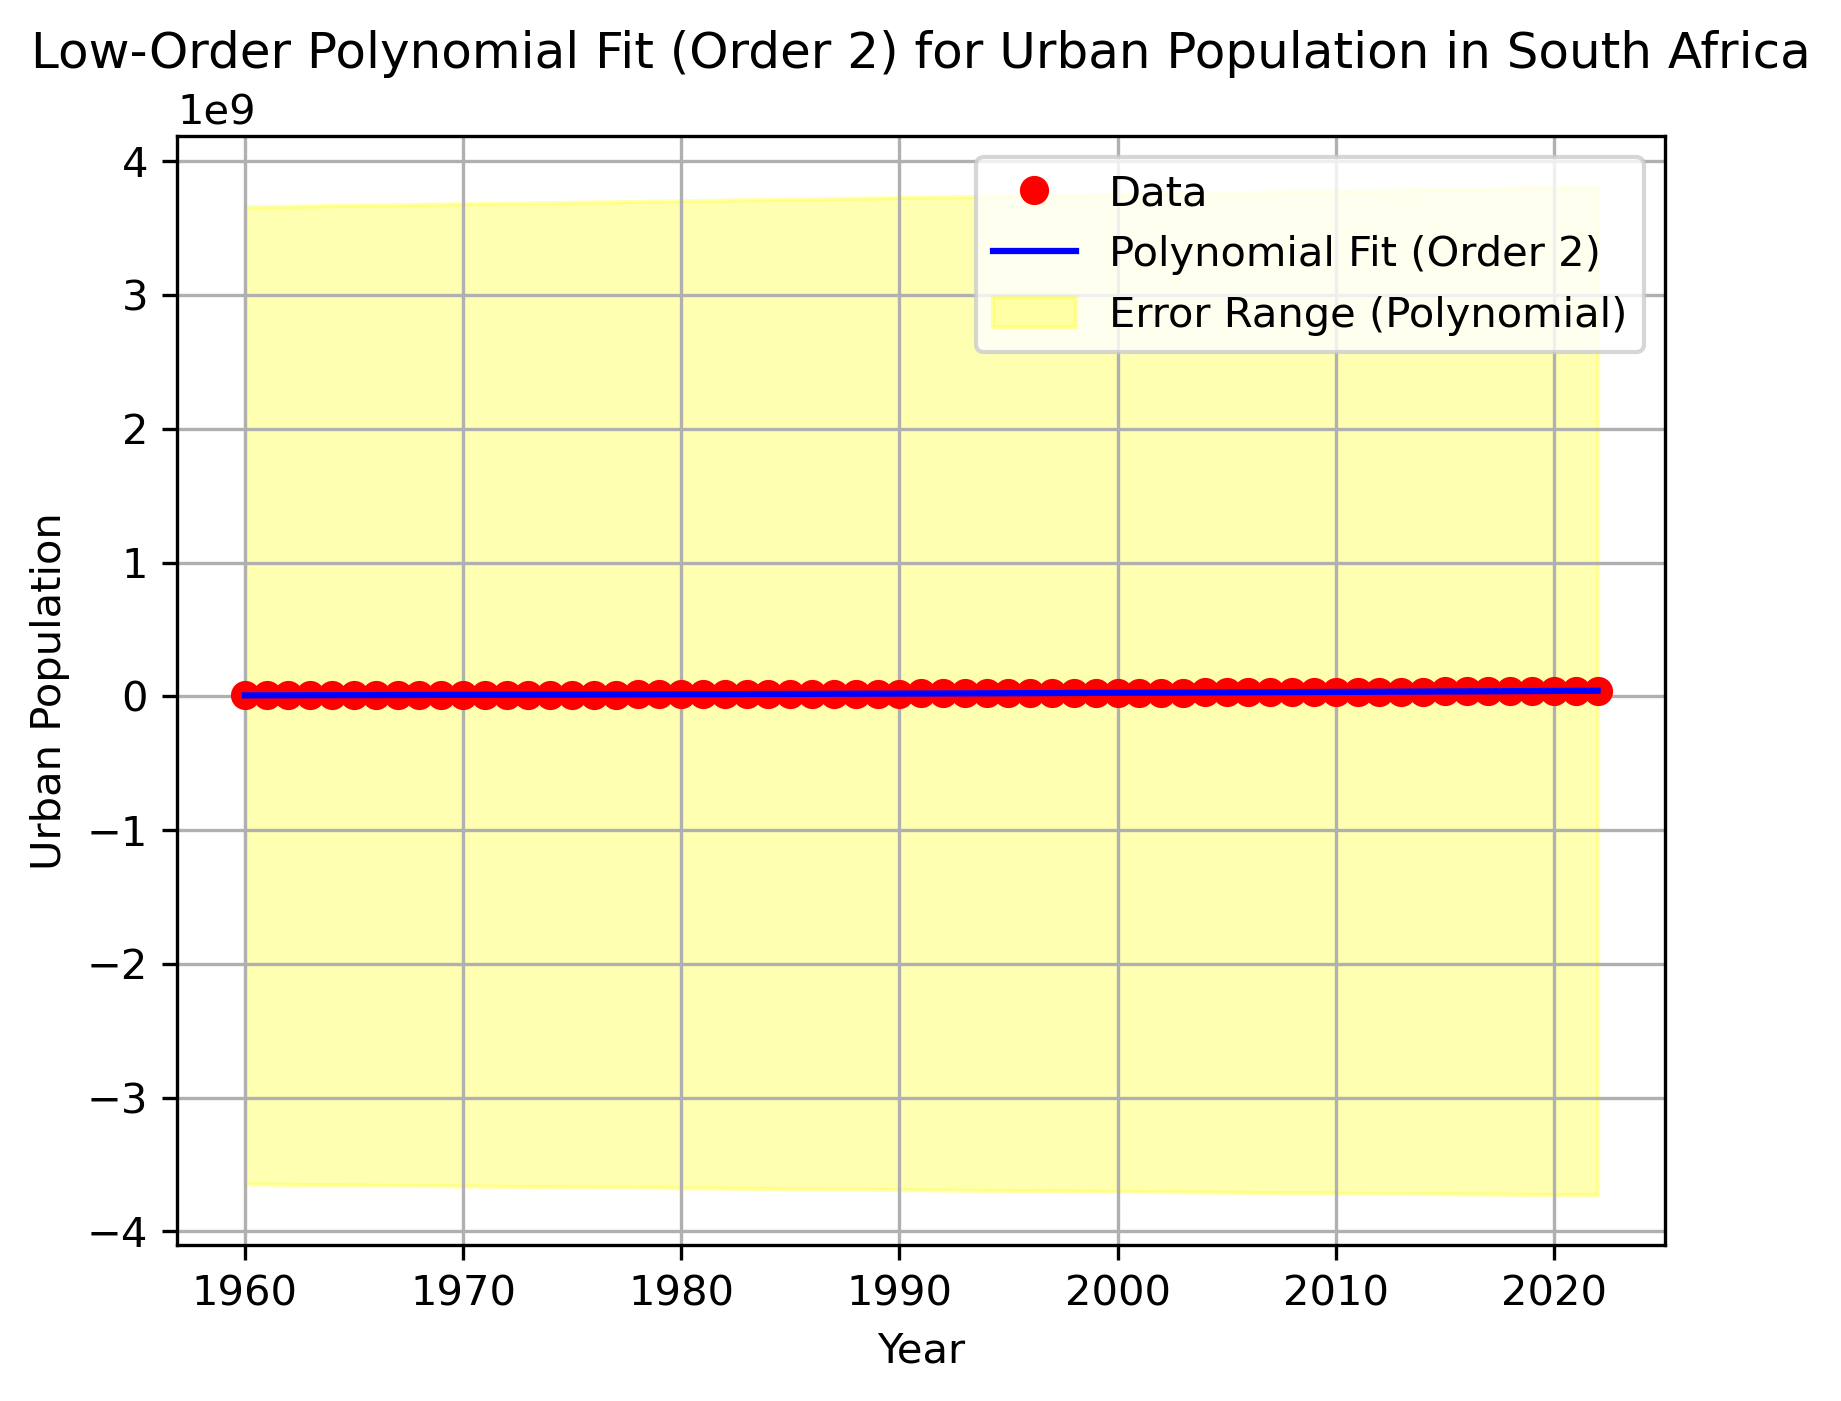

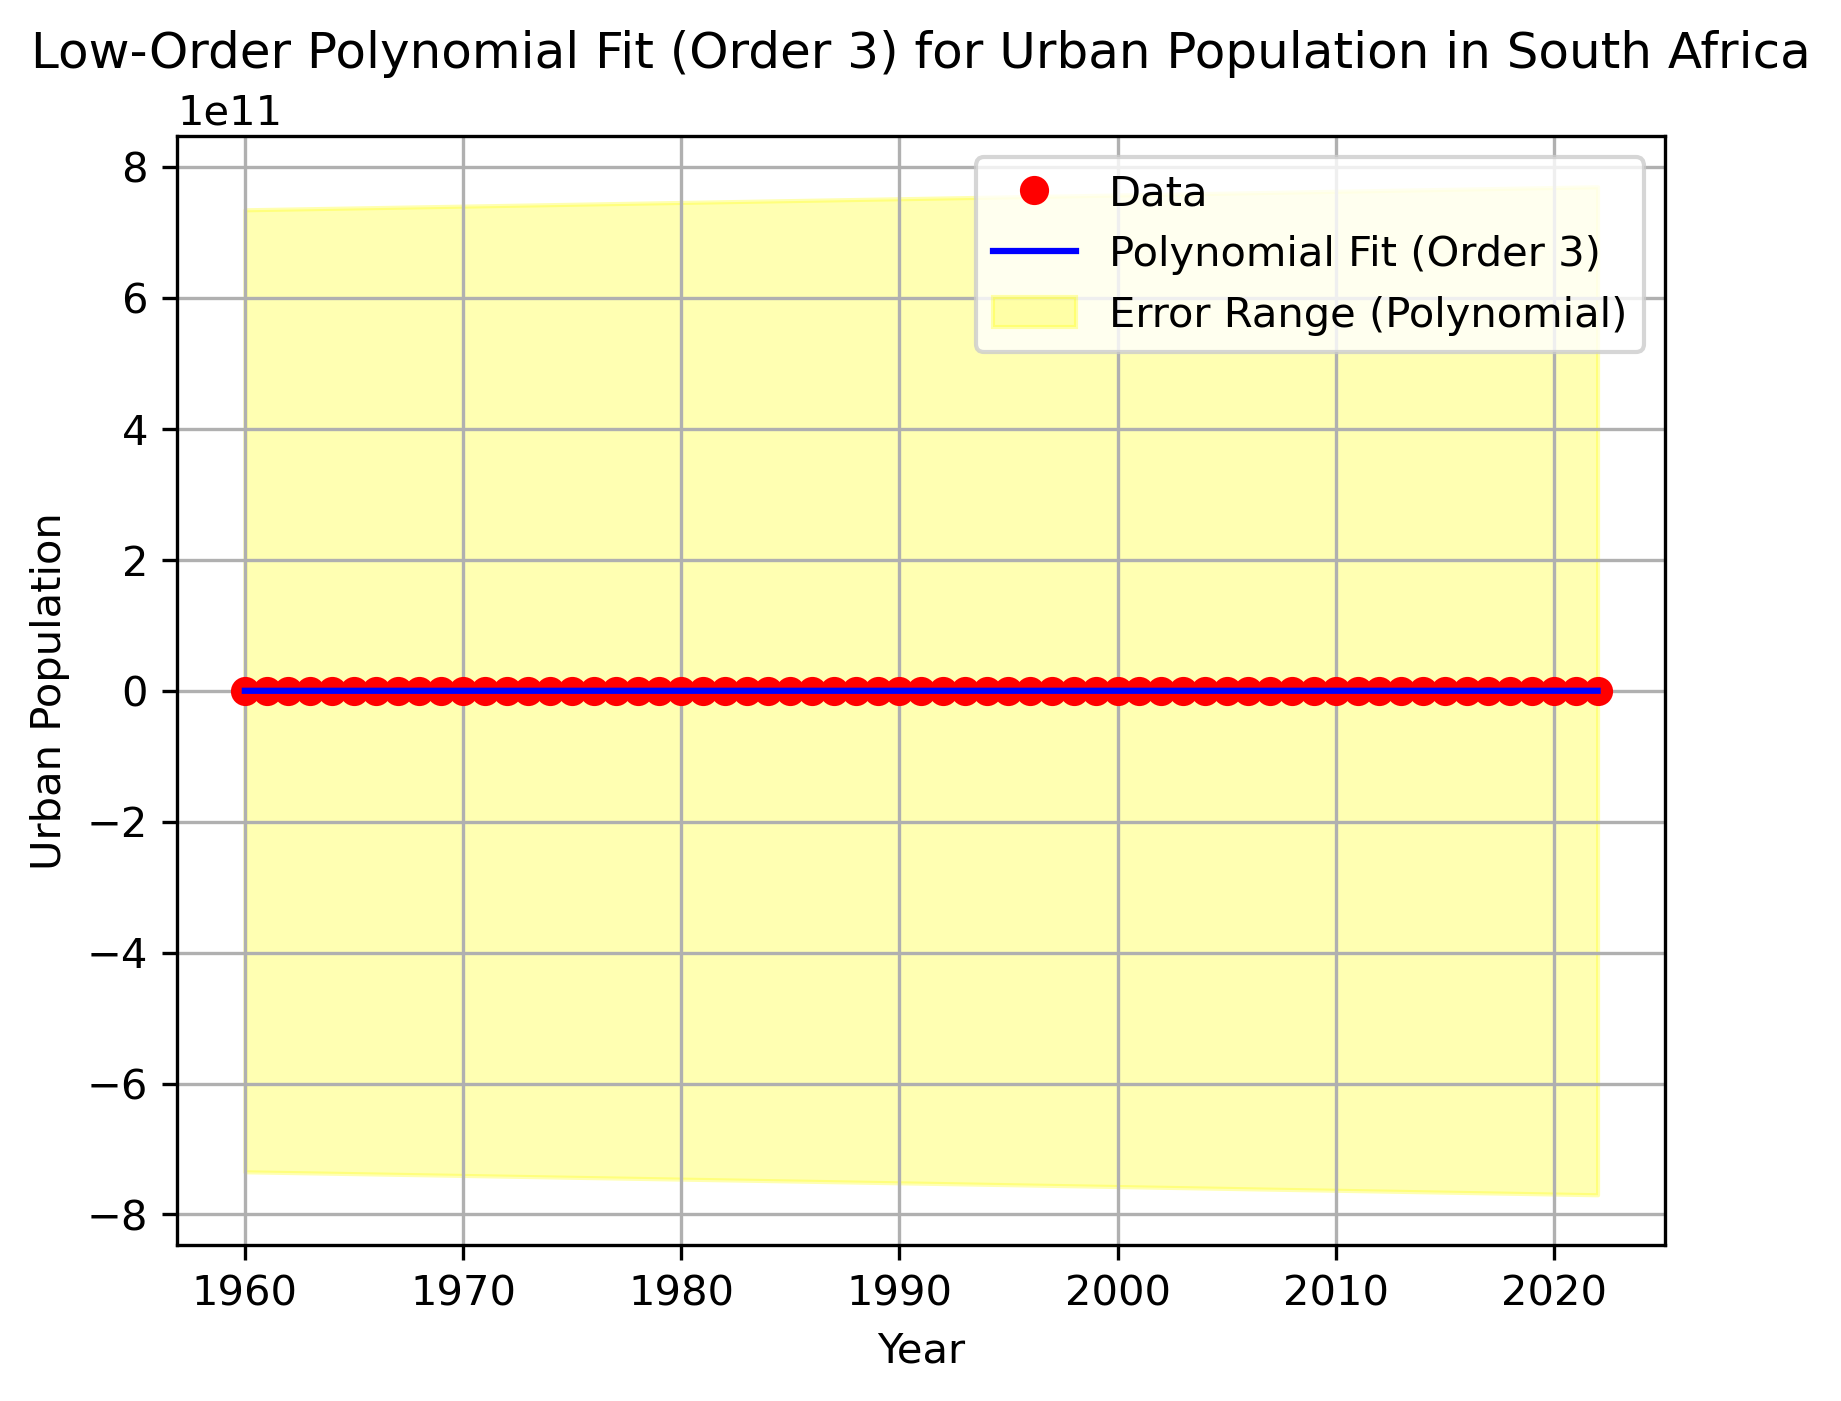

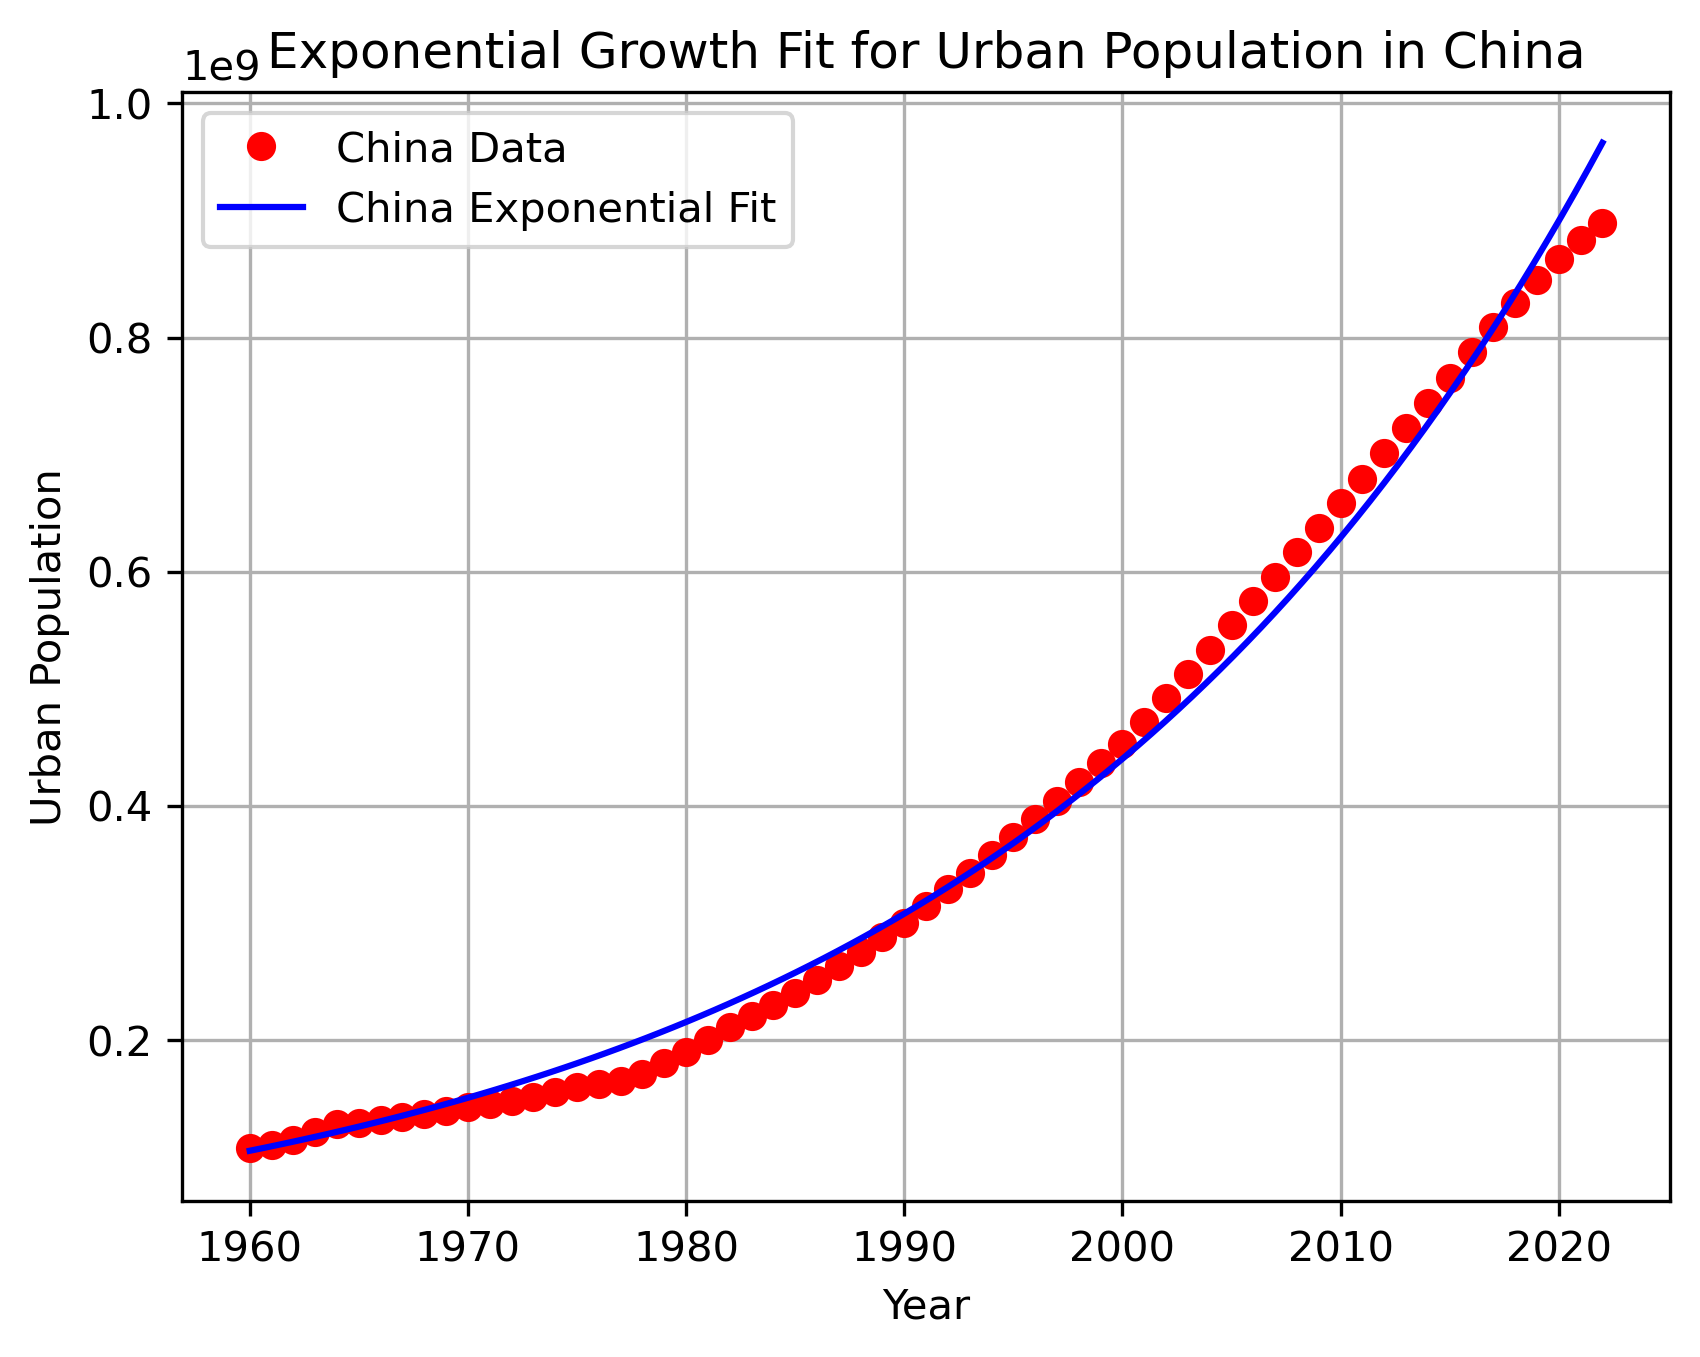

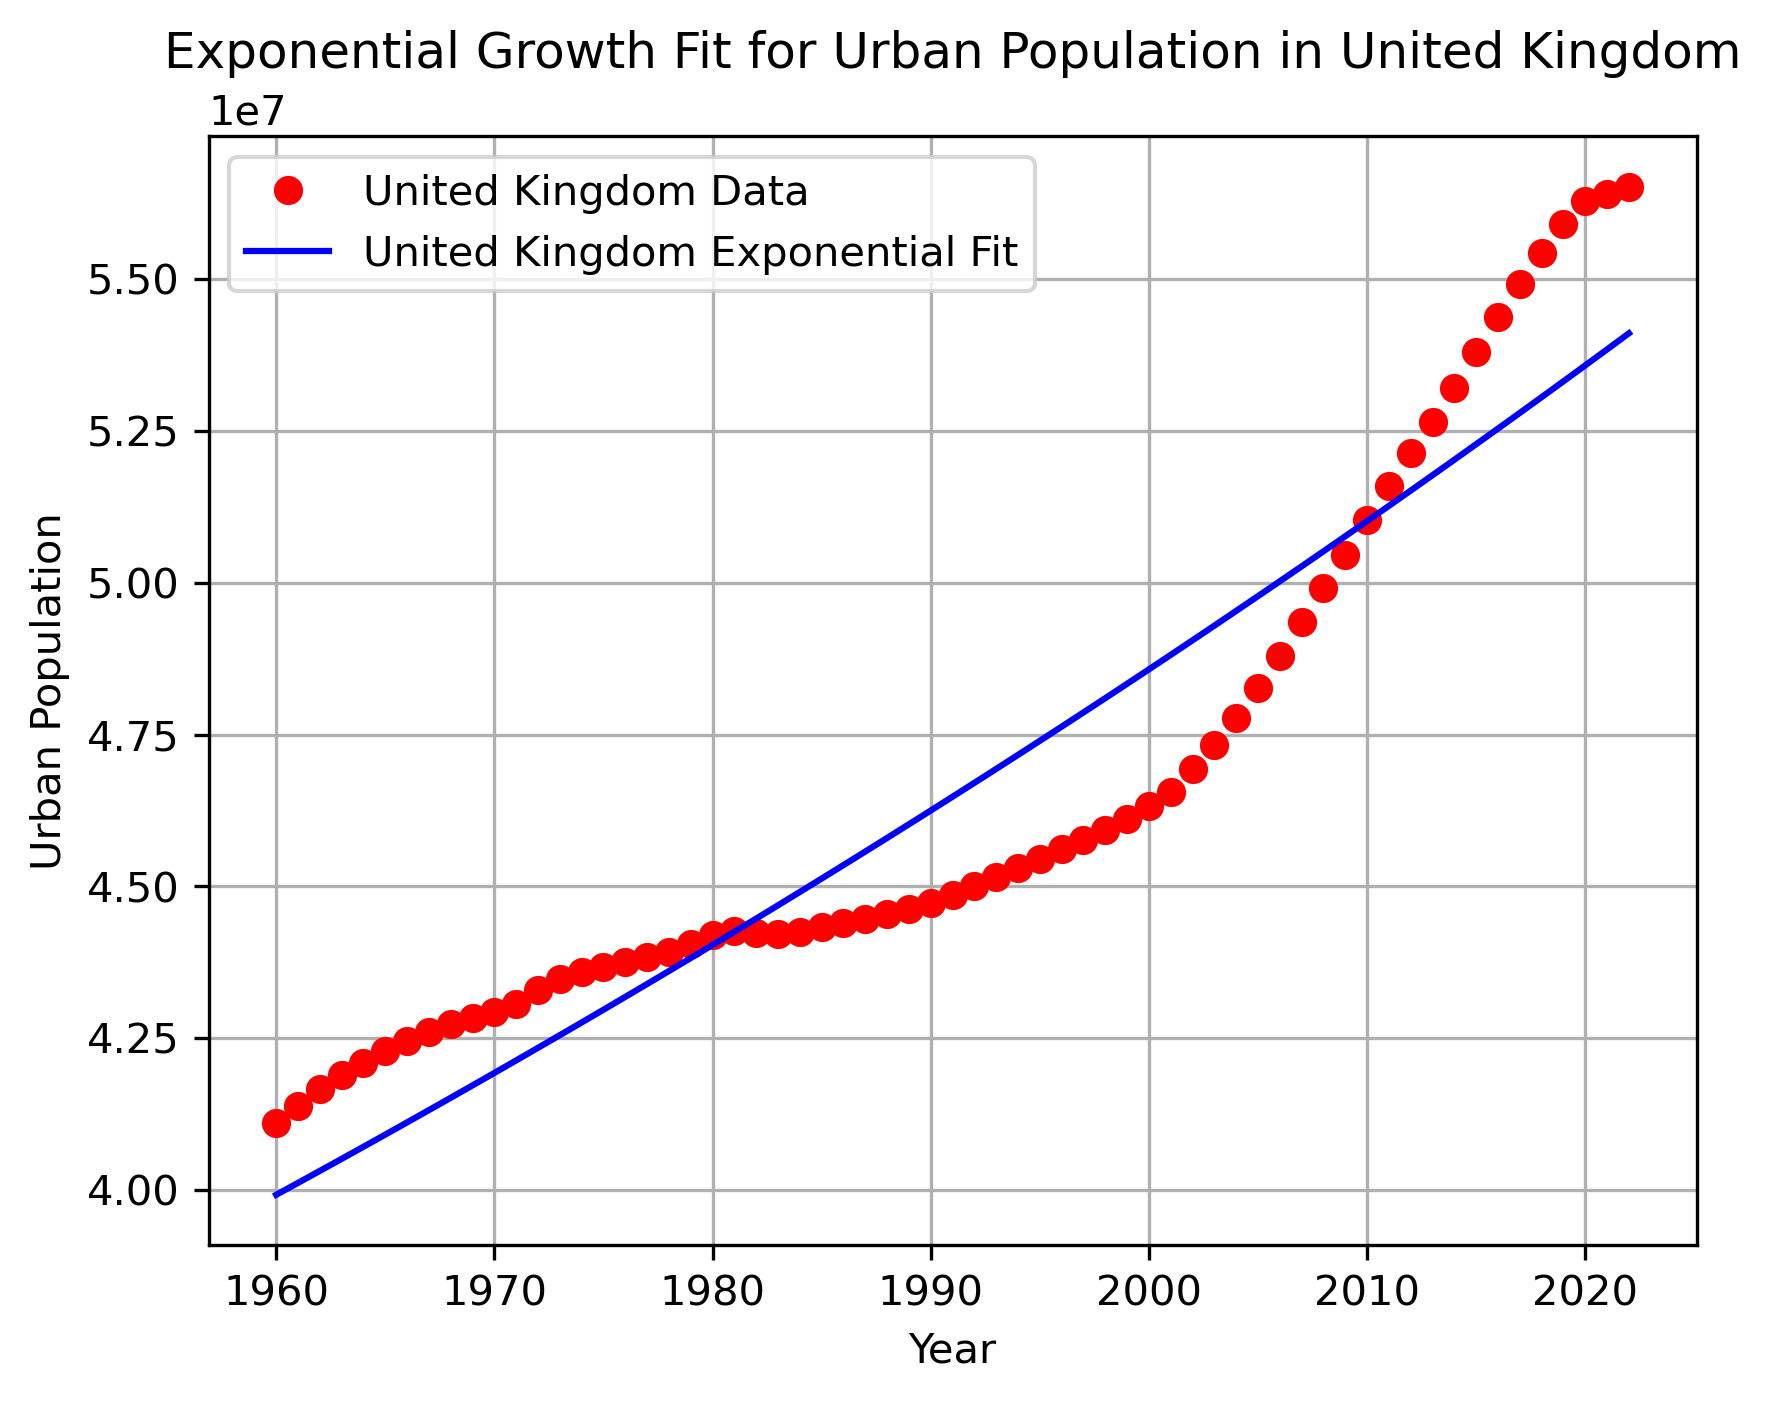

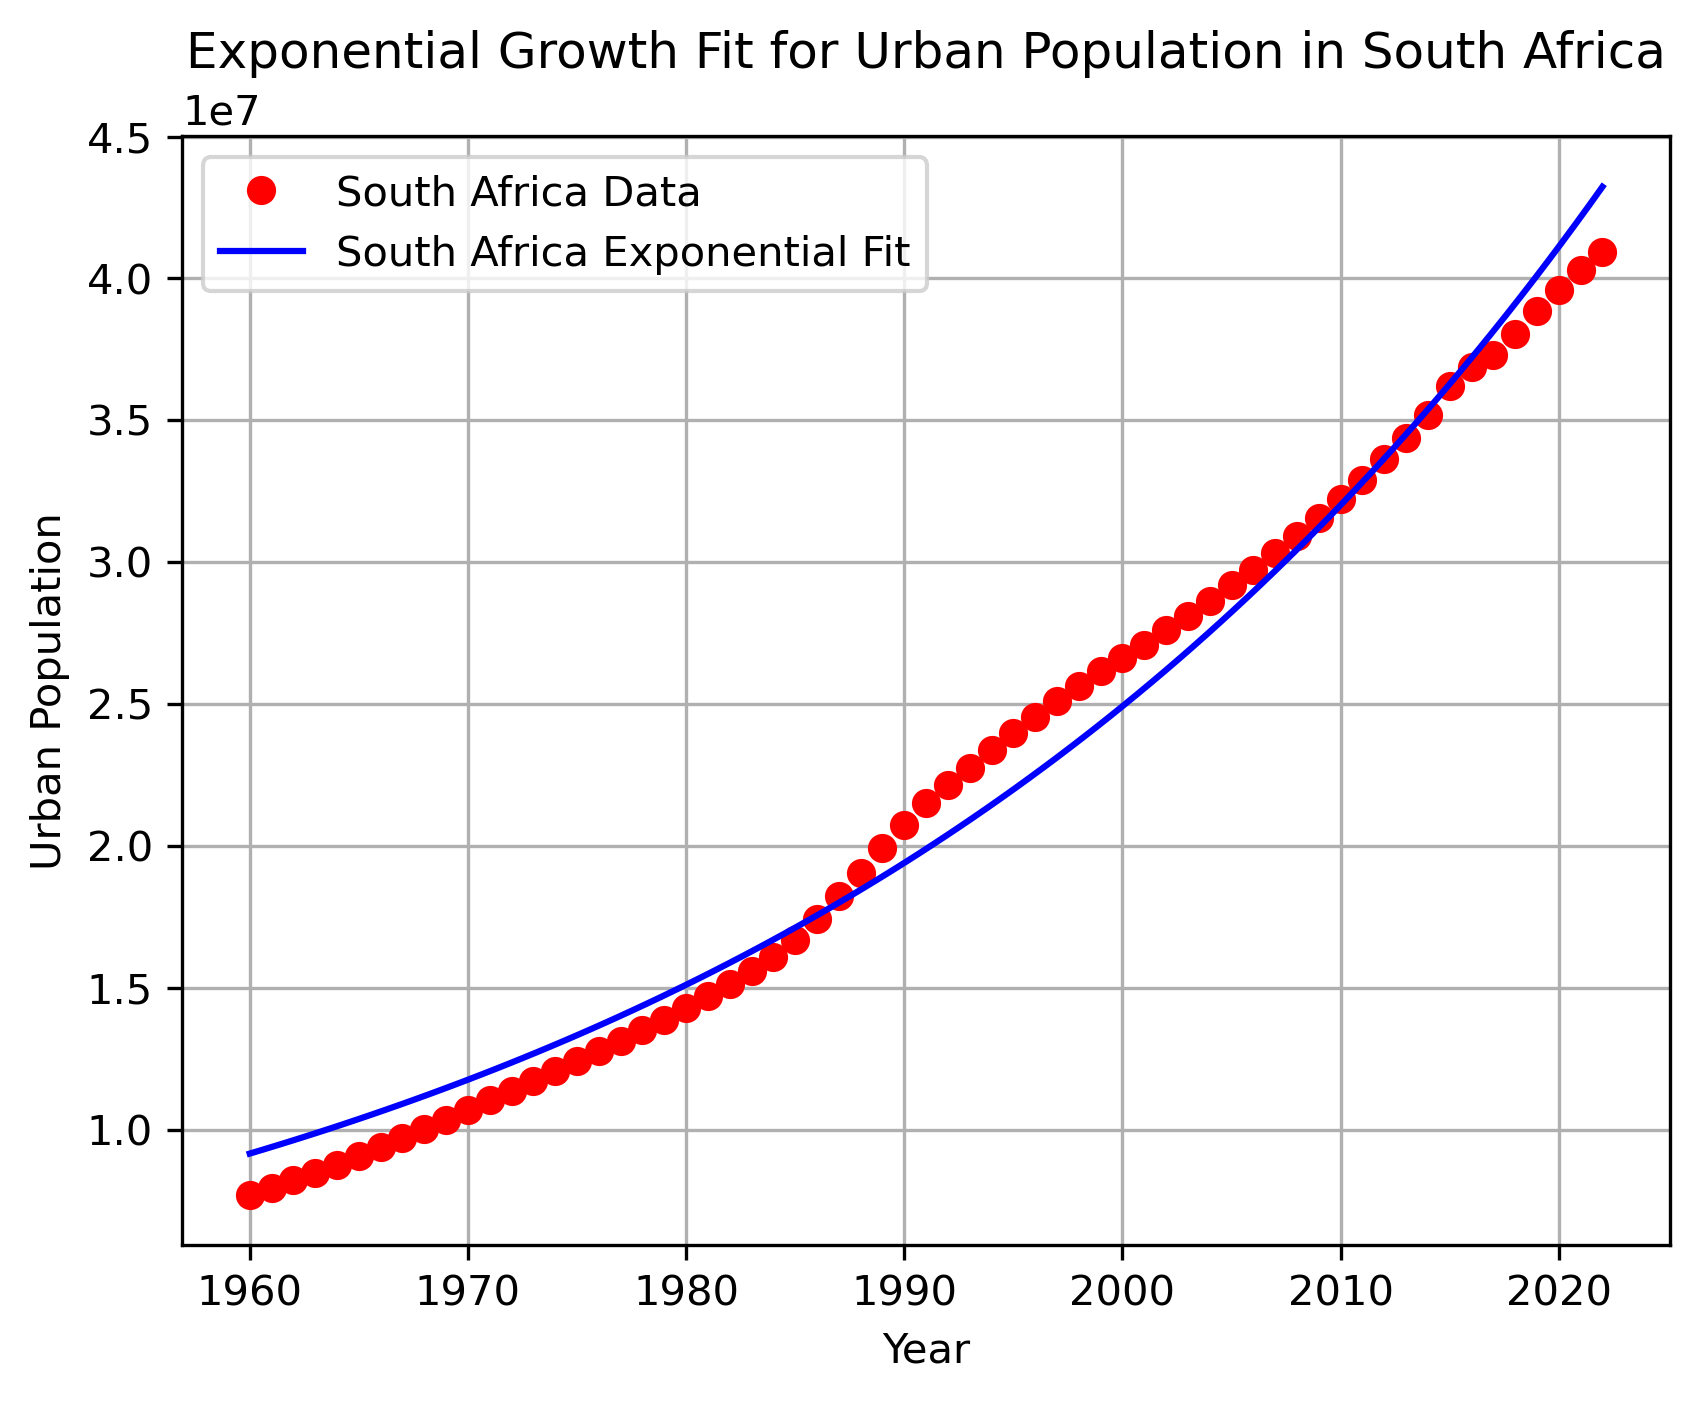

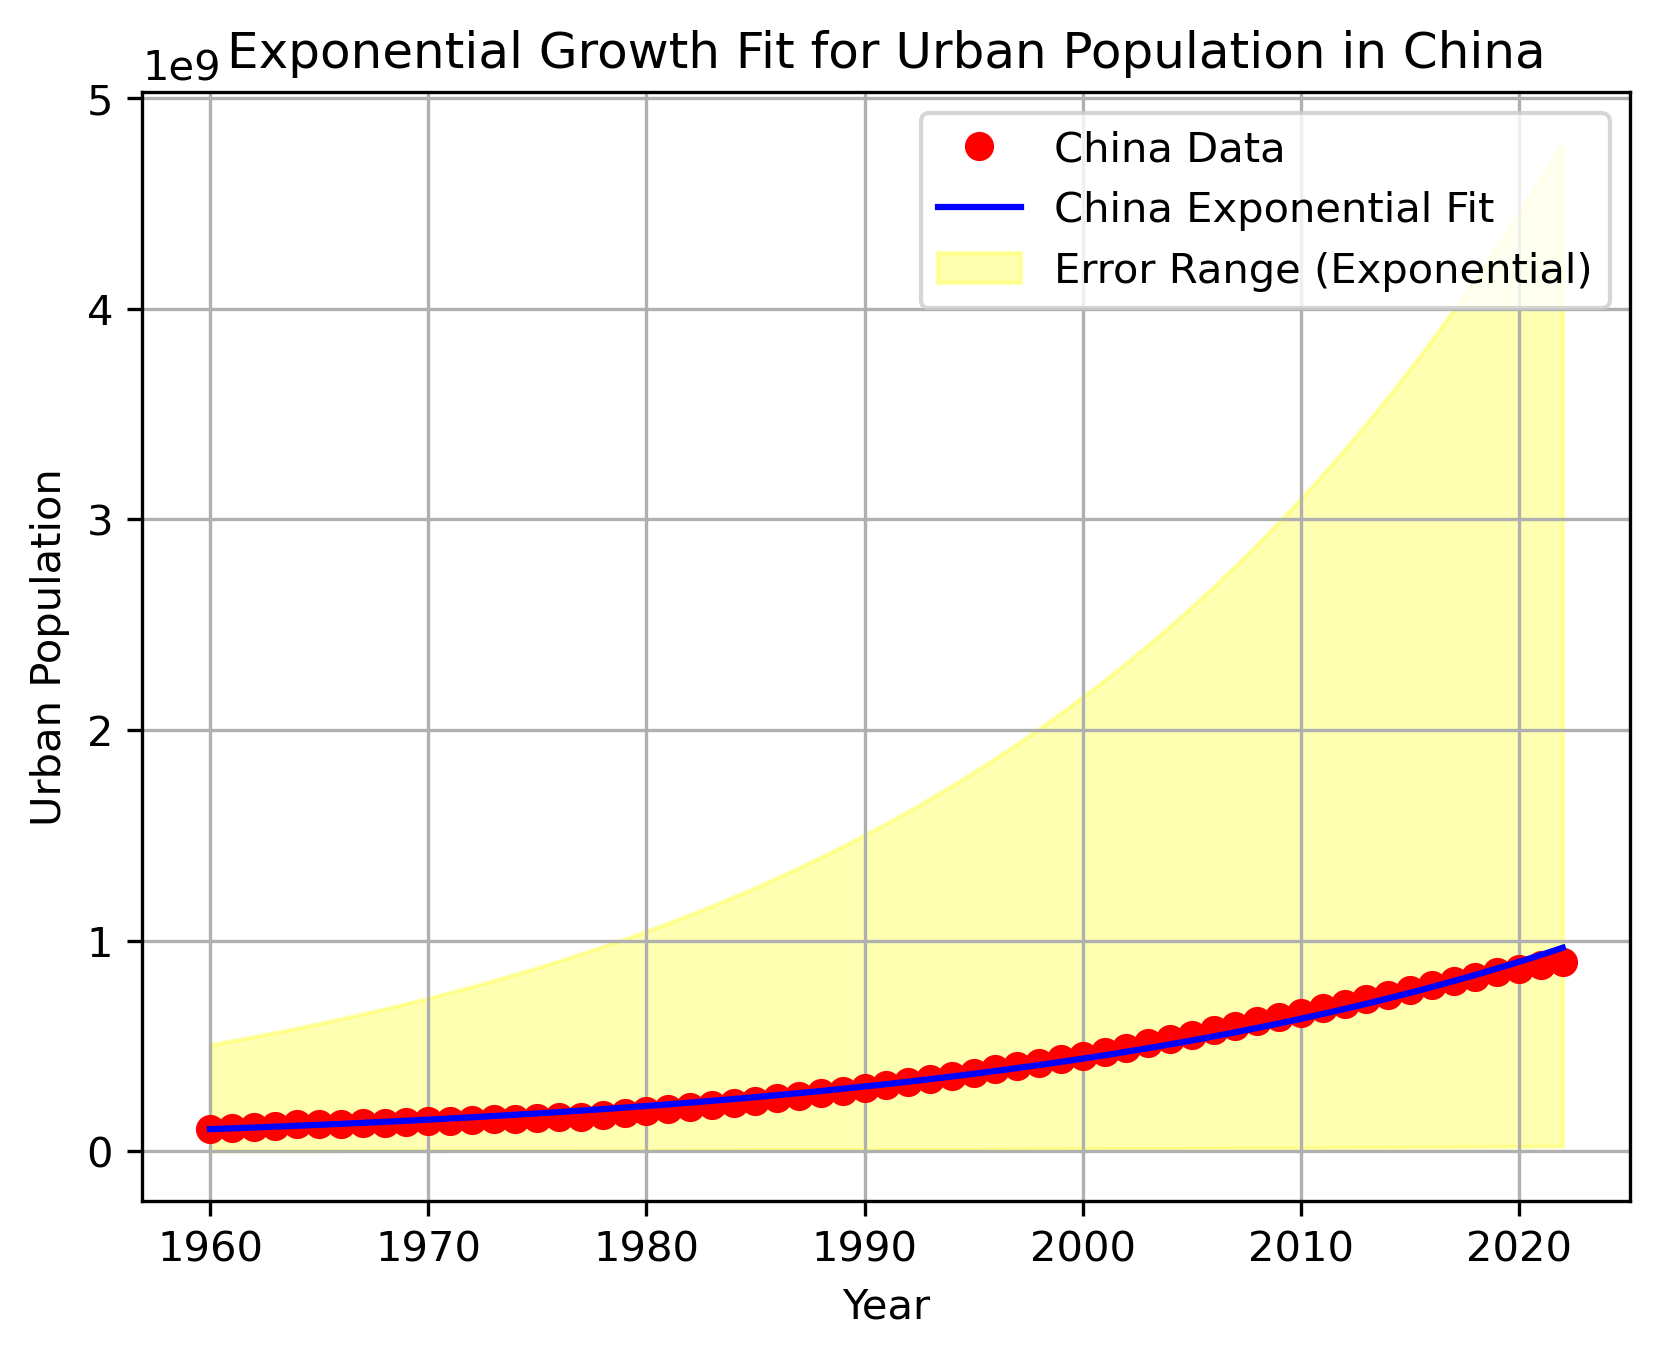

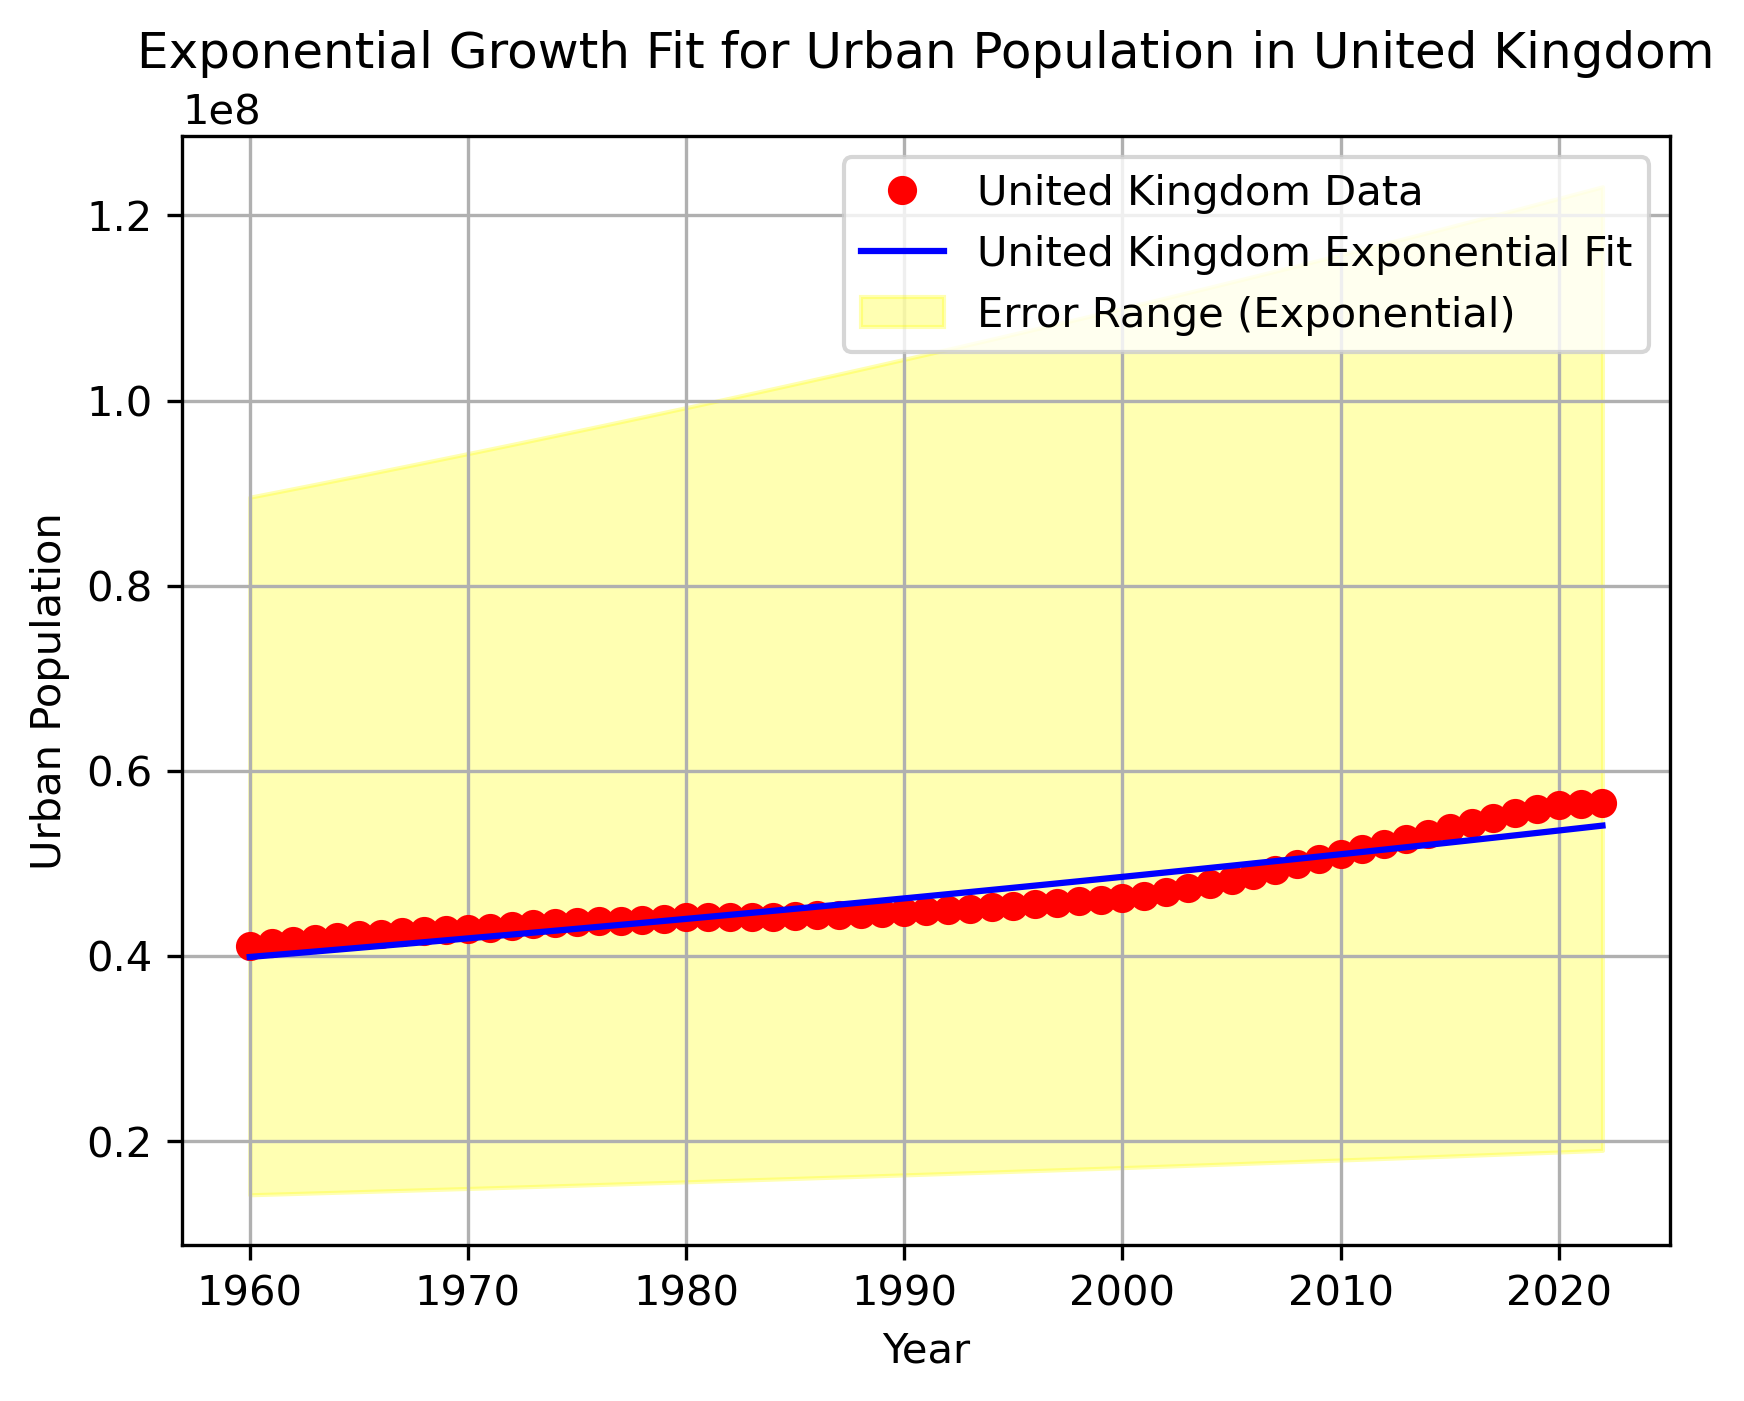

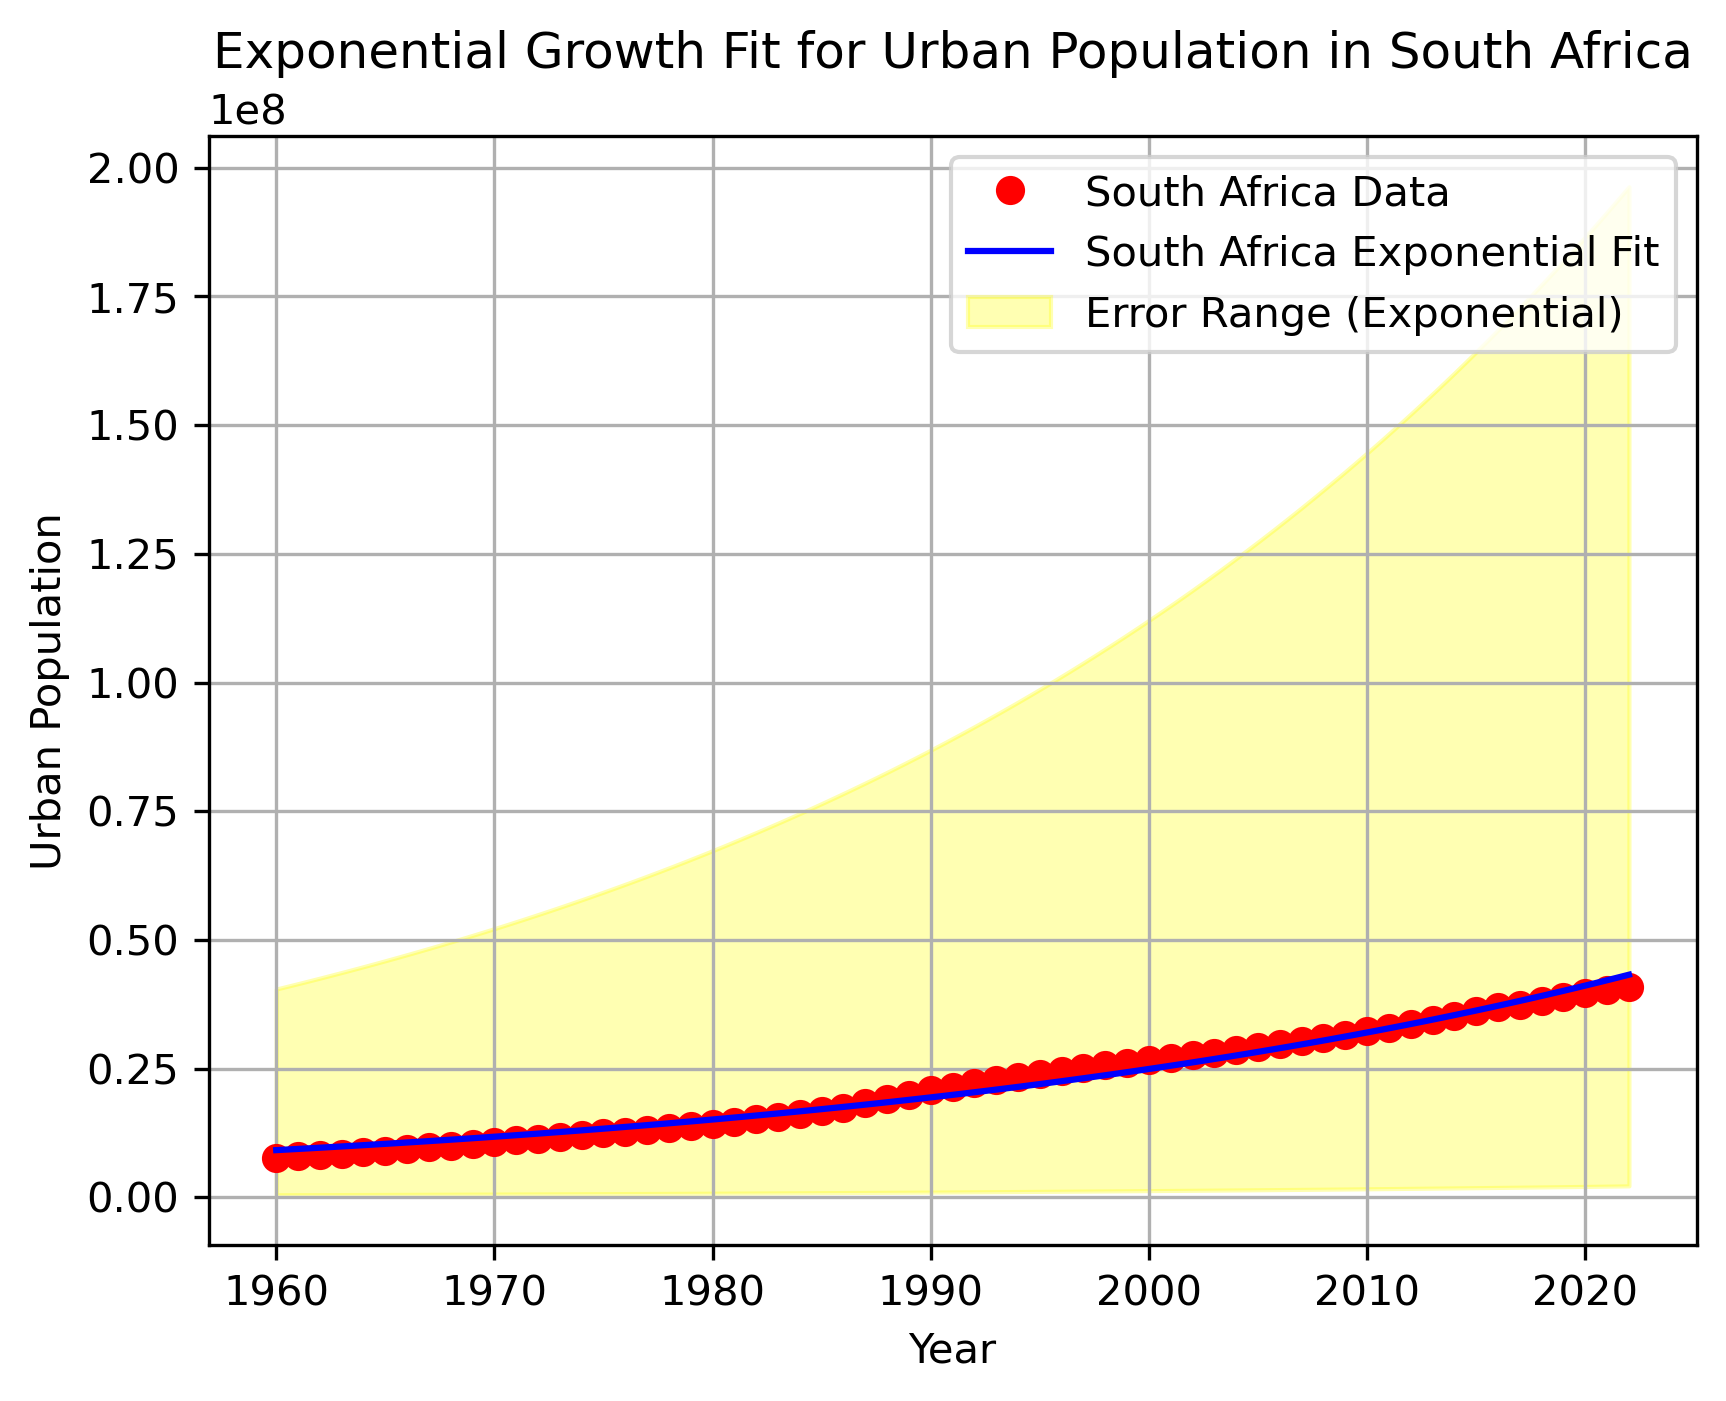

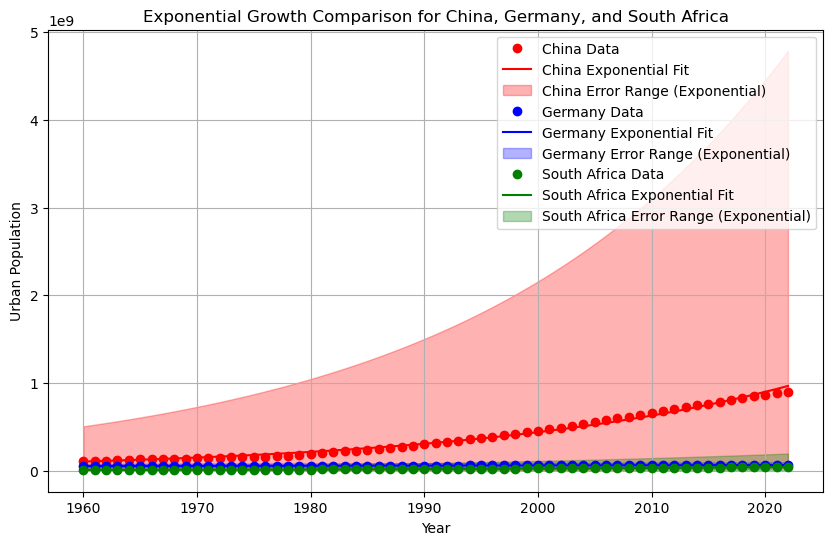

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 25 22:58:03 2024

@author: 22026656
"""

import pandas as pd
import numpy as np
import itertools as iter
import seaborn as sns
import os
import warnings
from lmfit import Model
import matplotlib.pyplot as plt
import cluster_tools as ct
from tabulate import tabulate
import scipy.optimize as opt
from scipy.optimize import curve_fit
import sklearn.cluster as cluster
import sklearn.metrics as skmet
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

def read_data(filename, **others):
    """
    A function that reads climate change data and returns the dataset with the 
    first 4 rows skipped.

    Parameters:
        filename (str): The name of the world bank data file.
        **others: Additional arguments to pass into the function, such as 
        skipping the first 4 rows.

    Returns:
        pd.DataFrame: The dataset with the first 4 rows skipped.
    """
    world_data = pd.read_csv(filename, skiprows=4)
    return world_data

# Read data
urban_data = read_data('API_SP.URB.TOTL_DS2_en_csv_v2_6301061.csv', 
                       skiprows=4)
urban_data.head()


warnings.filterwarnings("ignore")

# Selecting  the countries the needed
urban_data = urban_data[urban_data['Country Name'].isin(['China', 'Germany', 
                                                         'South Africa', 
                                                         'India', 
                                                         'United States', 
                                                         'Brazil',
                                          'Philippines', 'France', 
                                          'United Kingdom', 'Japan', 'Ghana', 
                                          'Canada'])]

# Dropping the columns not needed
urban_data = urban_data.drop(['Indicator Name', 'Country Code', 
                              'Indicator Code', 'Unnamed: 67'], axis=1)

# reseting the index
urban_data.reset_index(drop=True, inplace=True)

# Extracting  years from our urban out dataset

urban_s = urban_data[['Country Name', '1990', '2000', '2010', '2020']]
print(urban_s.describe())

# Checking for missing values
print(urban_s.isna().sum())

urban_data

# Transposing the data
urban_t = urban_s.T

urban_t.columns = urban_t.iloc[0]  # setting the columns
urban_t = urban_t.iloc[1:]  # filtering for only years
print(urban_t.describe())
urban_t = urban_t.apply(pd.to_numeric)  # converting the datatype to numeric

# Specify the size using figsize
urban_t.plot(figsize=(10, 6))

# Extracting 30 years of data at an interval of 10 years from the dataset
urban_yr = urban_s[['1990', '2000', '2010', '2020']]
urban_yr.describe()

# Checking for any missing values
urban_yr.isna().sum()

# Correlation
corr = urban_yr.corr()
corr

urban_yr.corr()

# Specify the size using figsize
urban_yr.plot(figsize=(10, 6))

plt.show()

# scatter plot
pd.plotting.scatter_matrix(urban_yr, figsize=(9.0, 9.0))
plt.suptitle('Scattered matrix for selected countries', fontsize=16)
plt.tight_layout()    # helps to avoid overlap of labels
plt.show()

urban_cluster = urban_yr[['1990', '2020']].copy()

print(urban_cluster)


def plot_heatmap():
    # load the dataset
    file_path = 'API_SP.URB.TOTL_DS2_en_csv_v2_6301061.csv'
    data = pd.read_csv(file_path, skiprows=4)
    # Checking if the specific years are present in the dataset
    columns_of_interest = ['2000', '2005', '2010', '2020']
    if all(item in data.columns for item in columns_of_interest):
        # Selecting only the years of interest
        data_years = data[columns_of_interest]
        # Calculating the correlation matrix
        correlation_matrix = data_years.corr()
        # Generating the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, 
                    cmap='coolwarm', linewidths=.5)
        plt.title('Heatmap of Correlation Between Selected Years')
        return plt.show()
       
plot_heatmap()

# # Normalizing the data and storing minimum and maximum value
# urban_norm, urban_min, urban_max = ct.scaler(urban_cluster)
# print(urban_norm.describe())

urban_cluster = urban_yr[['1990', '2020']].copy()

print(urban_cluster)

# Assuming urban_cluster is your DataFrame
scaler = StandardScaler()
urban_norm = scaler.fit_transform(urban_cluster)

# Get the minimum and maximum values
urban_min = urban_norm.min()
urban_max = urban_norm.max()

# Print normalized data statistics
print(pd.DataFrame(urban_norm, columns=urban_cluster.columns).describe())

# Calculating the best clustering number
#for i in range(2, 9):
    # creating  kmeans and fit
    #kmeans = cluster.KMeans(n_clusters=i)
    #kmeans.fit(urban_cluster)
    #urban_cluster

    # extract labels and calculate silhoutte score
    #labels = kmeans.labels_
    #print(i, skmet.silhouette_score(urban_cluster, labels))


# Set environment variable to suppress memory leak warning on Windows
os.environ['OMP_NUM_THREADS'] = '1'

# Calculating the silhouette score for different numbers of clusters
silhouette_scores = []

for i in range(2, 9):
    # Create KMeans model and fit
    kmeans = cluster.KMeans(n_clusters=i, n_init=10)  # Set n_init explicitly
    kmeans.fit(urban_cluster)

    # Extract labels and calculate silhouette score
    labels = kmeans.labels_
    score = skmet.silhouette_score(urban_cluster, labels)

    silhouette_scores.append((i, score))

# Print the silhouette scores
for n_clusters, score in silhouette_scores:
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {score}")

# Choose the number of clusters with the highest silhouett…

# Assuming urban_norm and urban_yr are your dataframes
# Extract the columns for clustering
features = ["1990", "2020"]
urban_norm = urban_yr[features]

# Plotting for 3 clusters
nclusters = 3  # number of cluster centres

kmeans = KMeans(n_clusters=nclusters)
kmeans.fit(urban_norm)

# Extract labels and cluster centers
labels = kmeans.labels_
cen = kmeans.cluster_centers_

# Scatter plot with colors selected using the cluster numbers
plt.figure(figsize=(10.0, 8.0))

plt.scatter(urban_yr["1990"], urban_yr["2020"], c=labels, cmap="tab10")

# Show cluster centres
xcen = cen[:, 0]
ycen = cen[:, 1]

plt.scatter(xcen, ycen, c="k", marker="d", s=80)
# c = color, s = size

plt.xlabel("Urban (1990)")
plt.ylabel("Urban (2020)")
plt.title("3 Clusters")
plt.show()

def plot_scatter_correlation(data):

    data = data.dropna()
    # Selecting a subset of years for clustering
    years_selected = ['2000', '2005', '2010', '2015', '2020']
    data_clustering = data[years_selected]

    # Standardizing the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_clustering)

    # Performing KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=0).fit(data_scaled)

    # Assigning cluster labels to the original data
    data['Cluster'] = kmeans.labels_

    # Visualizing the clusters using the first and last selected years for 
    # simplicity
    plt.figure(figsize=(10, 6))
    plt.scatter(data['2000'], data['2020'], c=data['Cluster'])
    plt.title
    ('K-Means Clustering of Urban Population of Selected (2000 vs 2020)')
    plt.xlabel('Urban Population in 2000')
    plt.ylabel('Urban Population in 2020')
    plt.colorbar(label='Cluster Label')
    return plt.show()

file_path = 'API_SP.URB.TOTL_DS2_en_csv_v2_6301061.csv'
corr_data = pd.read_csv(file_path, skiprows=4)
plot_scatter_correlation(urban_data)

"""
Curve fitting solution
"""
# calling in the urban population data
urban_data
# Transposing the data
urban_data = urban_data.T

# Making the country name the colums
print(urban_data)

# Making the country name the colums
urban_data.columns = urban_data.iloc[0]

# Selecting only the years
urban_data = urban_data.iloc[1:]

# resetting the index
#urban.reset_index(drop=True, inplace=True)

urban_data.reset_index(inplace=True)

urban_data.rename(columns={'index': 'Year'}, inplace=True)

# renaming the country name to years
urban_data.rename(columns={'Country Name': 'Year'}, inplace=True)

urban_data = urban_data.apply(pd.to_numeric)  # converting to numeric
print(urban_data.dtypes)  # checking the types

# Fitting for Germany on Exponential Growth


def exponential(t, a, b):
    """Computes exponential growth of urban population

    Parameters:
        t: The current time
        a: The initial population
        b: The growth rate

    Returns:
        The population at the given time
    """
    f = a * np.exp(b * t)
    return f


def err_range(x, func, param, sigma):
    """Calculates the error range for a given function and its parameters

    Parameters:
        x: The input value for the function
        func: The function for which the error ranges will be calculated
        param: The parameters for the function
        sigma: The standard deviation of the data

    Returns:
        The lower and upper error ranges
    """
    lower = func(x, *param)
    upper = lower

    for i, p in enumerate(param):
        pmin = p - sigma[i]
        pmax = p + sigma[i]
        y = func(x, *param[:i], pmin, *param[i+1:])
        lower = np.minimum(lower, y)
        y = func(x, *param[:i], pmax, *param[i+1:])
        upper = np.maximum(upper, y)

    return lower, upper


def urban_population_growth(country_name):
    years = urban_data['Year'].values
    population = urban_data[country_name].values

    # Check for NaN values
    nan_indices = np.isnan(population)

    # Remove NaN values
    population = population[~nan_indices]
    years = years[~nan_indices]


    # Provide initial guess for exponential function
    # You can adjust the initial guess if needed
    initial_guess = [min(population), 0.01]

    popt, pcov = curve_fit(exponential, years, population,
                          p0=initial_guess, maxfev=5000)  # Increase maxfev

    prediction_2030 = exponential(2030, *popt)
    prediction_2040 = exponential(2040, *popt)

    print("Urban population prediction for 2030:", prediction_2030)
    print("Urban population prediction for 2040:", prediction_2040)

    # Generate points for the fitted curve
    curve_years = np.linspace(min(years), max(years), 100)
    predicted_years = np.array([2030, 2040])  # Add the predicted years here
    curve_years_extended = np.concatenate((curve_years, predicted_years))

    curve_population = exponential(curve_years_extended, *popt)

    # Calculate error range
    sigma = np.sqrt(np.diag(pcov))
    lower, upper = err_range(curve_years_extended, exponential, popt, sigma)

    # Plot the data, fitted curve, and error range
    plt.figure(dpi=300)
    plt.plot(years, population, 'ro', label='Data')
    plt.plot(curve_years_extended, curve_population, 'b-', 
             label='Fitted Curve')
    plt.fill_between(curve_years_extended, lower, upper,
                    color='yellow', alpha=0.3, label='Error Range')
    plt.xlabel('Year')
    plt.ylabel('Urban Population')
    plt.title(f'Exponential Growth Fit for Urban Population in {country_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

urban_population_growth('Germany')



# Fitting for China on Exponential Growth


def exponential(t, a, b):
    """Computes exponential growth of urban population

    Parameters:
        t: The current time
        a: The initial population
        b: The growth rate

    Returns:
        The population at the given time
    """
    f = a * np.exp(b * t)
    return f


def err_range(x, func, param, sigma):
    """Calculates the error range for a given function and its parameters

    Parameters:
        x: The input value for the function
        func: The function for which the error ranges will be calculated
        param: The parameters for the function
        sigma: The standard deviation of the data

    Returns:
        The lower and upper error ranges
    """
    lower = func(x, *param)
    upper = lower

    for i, p in enumerate(param):
        pmin = p - sigma[i]
        pmax = p + sigma[i]
        y = func(x, *param[:i], pmin, *param[i+1:])
        lower = np.minimum(lower, y)
        y = func(x, *param[:i], pmax, *param[i+1:])
        upper = np.maximum(upper, y)

    return lower, upper


def urban_population_growth(country_name):
    years = urban_data['Year'].values
    population = urban_data[country_name].values

    # Check for NaN values
    nan_indices = np.isnan(population)

    # Remove NaN values
    population = population[~nan_indices]
    years = years[~nan_indices]


    # Provide initial guess for exponential function
    # You can adjust the initial guess if needed
    initial_guess = [min(population), 0.01]

    popt, pcov = curve_fit(exponential, years, population,
                          p0=initial_guess, maxfev=5000)  # Increase maxfev

    prediction_2030 = exponential(2030, *popt)
    prediction_2040 = exponential(2040, *popt)

    print("Urban population prediction for 2030:", prediction_2030)
    print("Urban population prediction for 2040:", prediction_2040)

    # Generate points for the fitted curve
    curve_years = np.linspace(min(years), max(years), 100)
    predicted_years = np.array([2030, 2040])  # Add the predicted years here
    curve_years_extended = np.concatenate((curve_years, predicted_years))

    curve_population = exponential(curve_years_extended, *popt)

    # Calculate error range
    sigma = np.sqrt(np.diag(pcov))
    lower, upper = err_range(curve_years_extended, exponential, popt, sigma)

    # Plot the data, fitted curve, and error range
    plt.figure(dpi=300)
    plt.plot(years, population, 'ro', label='Data')
    plt.plot(curve_years_extended, curve_population, 'b-', 
             label='Fitted Curve')
    plt.fill_between(curve_years_extended, lower, upper,
                    color='yellow', alpha=0.3, label='Error Range')
    plt.xlabel('Year')
    plt.ylabel('Urban Population')
    plt.title(f'Exponential Growth Fit for Urban Population in {country_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

urban_population_growth('China')




# Fitting for United Kingdom on Logistic Growth
def logistic(t, a, b, c):
    """Computes logistic growth of urban population

    Parameters:
        t: The current time
        a: The carrying capacity
        b: The growth rate
        c: The time of maximum growth

    Returns:
        The population at the given time
    """
    x = -b * (t - c)
    # Use np.clip to limit the values to prevent overflow in np.exp
    exp_term = np.exp(np.clip(x, -700, 700))
    f = a / (1 + exp_term)
    return f

def err_range(x, func, param, sigma):
    """Calculates the error range for a given function and its parameters

    Parameters:
        x: The input value for the function
        func: The function for which the error ranges will be calculated
        param: The parameters for the function
        sigma: The standard deviation of the data

    Returns:
        The lower and upper error ranges
    """
    lower = func(x, *param)
    upper = lower

    for i, p in enumerate(param):
        pmin = p - sigma[i]
        pmax = p + sigma[i]
        y = func(x, *param[:i], pmin, *param[i+1:])
        lower = np.minimum(lower, y)
        y = func(x, *param[:i], pmax, *param[i+1:])
        upper = np.maximum(upper, y)

    return lower, upper

# Your data (years and population) and the NaN handling remain the same...
years = urban_data['Year'].values
population = urban_data['United Kingdom'].values

# Check for NaN values
nan_indices = np.isnan(population)

# Remove NaN values
population = population[~nan_indices]
years = years[~nan_indices]



# Provide initial guess for logistic function
initial_guess_logistic = [max(population), 1, np.median(years)]

# Curve fitting for logistic function
popt_logistic, pcov_logistic = curve_fit(logistic, years, population,
                                          p0=initial_guess_logistic, 
                                          maxfev=7000)

# Calculate predictions for 2030 and 2040 using the logistic function
prediction_2030_logistic = logistic(2030, *popt_logistic)
prediction_2040_logistic = logistic(2040, *popt_logistic)

print("Urban population prediction for 2030:", prediction_2030_logistic)
print("Urban population prediction for 2040:", prediction_2040_logistic)


# Generate points for the fitted curve
curve_years = np.linspace(min(years), max(years), 100)
curve_population_logistic = logistic(curve_years, *popt_logistic)

# Calculate error range
sigma_logistic = np.sqrt(np.diag(pcov_logistic))
lower_logistic, upper_logistic = err_range(curve_years, logistic, 
                                           popt_logistic, sigma_logistic)

# Plot the data, fitted curve, and error range for logistic function
plt.figure(dpi=300)
plt.plot(years, population, 'ro', label='Data')
plt.plot(curve_years, curve_population_logistic, 'b-', 
         label='Fitted Logistic Curve')
plt.fill_between(curve_years, lower_logistic, upper_logistic,
                 color='yellow', alpha=0.3, label='Error Range (Logistic)')
plt.xlabel('Year')
plt.ylabel('Urban Population')
plt.title('Logistic Growth Fit for Urban Population in United Kingdom')
plt.legend()
plt.grid(True)
plt.show()

def fit_and_plot_polynomial(years, population, order):
    # Remove NaN values
    nan_indices = np.isnan(population)
    population = population[~nan_indices]
    years = years[~nan_indices]

    # Fit low-order polynomial
    coeff_poly = np.polyfit(years, population, order)

    # Generate points for the fitted polynomial
    curve_years = np.linspace(min(years), max(years), 100)
    curve_poly = np.polyval(coeff_poly, curve_years)

    # Plot the data and fitted polynomial
    plt.figure(dpi=300)
    plt.plot(years, population, 'ro', label='Data')
    plt.plot(curve_years, curve_poly, 'b-', 
             label=f'Polynomial Fit (Order {order})')
    plt.xlabel('Year')
    plt.ylabel('Urban Population')
    plt.title(f'Low-Order Polynomial Fit (Order {order}) for Urban Population in South Africa')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming urban_data is your DataFrame with 'Year' and 'China' columns
years = urban_data['Year'].values
population = urban_data['South Africa'].values

# Fit and plot quadratic polynomial
fit_and_plot_polynomial(years, population, order=2)

# Fit and plot cubic polynomial
fit_and_plot_polynomial(years, population, order=3)

# Fitting for South Africa

def fit_and_plot_polynomial(years, population, order):
    # Remove NaN values
    nan_indices = np.isnan(population)
    population = population[~nan_indices]
    years = years[~nan_indices]

    # Fit low-order polynomial
    coeff_poly, cov_poly = np.polyfit(years, population, order, cov=True)

    # Generate points for the fitted polynomial
    curve_years = np.linspace(min(years), max(years), 100)
    curve_poly = np.polyval(coeff_poly, curve_years)

    # Calculate error range
    sigma_poly = np.sqrt(np.diag(cov_poly))
    lower_poly = np.polyval(coeff_poly - sigma_poly, curve_years)
    upper_poly = np.polyval(coeff_poly + sigma_poly, curve_years)

    # Plot the data, fitted polynomial, and error range
    plt.figure(dpi=300)
    plt.plot(years, population, 'ro', label='Data')
    plt.plot(curve_years, curve_poly, 'b-', 
             label=f'Polynomial Fit (Order {order})')
    plt.fill_between(curve_years, lower_poly, upper_poly,
                     color='yellow', alpha=0.3, 
                     label='Error Range (Polynomial)')
    plt.xlabel('Year')
    plt.ylabel('Urban Population')
    plt.title(f'Low-Order Polynomial Fit (Order {order}) for Urban Population in South Africa')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming urban_data is your DataFrame with 'Year' and 'China' columns
years = urban_data['Year'].values
population = urban_data['South Africa'].values

# Fit and plot quadratic polynomial
fit_and_plot_polynomial(years, population, order=2)

# Fit and plot cubic polynomial
fit_and_plot_polynomial(years, population, order=3)

# Exponential Growth comparison for China, United Kingdom, and South Africa


def exponential(t, a, b):
    """Computes exponential growth of urban population

    Parameters:
        t: The current time
        a: The initial population
        b: The growth rate

    Returns:
        The population at the given time
    """
    f = a * np.exp(b * t)
    return f

def fit_and_plot_exponential(country_data, country_name):
    # Extract data for the specific country
    years = country_data['Year'].values
    population = country_data[country_name].values

    # Remove NaN values
    nan_indices = np.isnan(population)
    population = population[~nan_indices]
    years = years[~nan_indices]

    # Provide initial guess for exponential function
    initial_guess_exp = [min(population), 0.01]

    # Curve fitting for exponential function
    popt_exp, pcov_exp = curve_fit(exponential, years, population,
                                   p0=initial_guess_exp, maxfev=5000)

    # Generate points for the fitted exponential curve
    curve_years = np.linspace(min(years), max(years), 100)
    curve_exp = exponential(curve_years, *popt_exp)

    # Plot the data and fitted exponential curve
    plt.figure(dpi=300)
    plt.plot(years, population, 'ro', label=f'{country_name} Data')
    plt.plot(curve_years, curve_exp, 'b-', 
             label=f'{country_name} Exponential Fit')
    plt.xlabel('Year')
    plt.ylabel('Urban Population')
    plt.title(f'Exponential Growth Fit for Urban Population in {country_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming urban_data is your DataFrame with 'Year', 'China', 'United Kingdom', 
# and 'South Africa' columns
# Replace this with your actual data
china_data = urban_data[['Year', 'China']]
uk_data = urban_data[['Year', 'United Kingdom']]
sa_data = urban_data[['Year', 'South Africa']]

# Fit and plot exponential growth for each country
fit_and_plot_exponential(china_data, 'China')
fit_and_plot_exponential(uk_data, 'United Kingdom')
fit_and_plot_exponential(sa_data, 'South Africa')

def exponential(t, a, b):
    """Computes exponential growth of urban population

    Parameters:
        t: The current time
        a: The initial population
        b: The growth rate

    Returns:
        The population at the given time
    """
    f = a * np.exp(b * t)
    return f

def fit_and_plot_exponential(country_data, country_name):
    # Extract data for the specific country
    years = country_data['Year'].values
    population = country_data[country_name].values

    # Remove NaN values
    nan_indices = np.isnan(population)
    population = population[~nan_indices]
    years = years[~nan_indices]

    # Provide initial guess for exponential function
    initial_guess_exp = [min(population), 0.01]

    # Curve fitting for exponential function
    popt_exp, pcov_exp = curve_fit(exponential, years, population,
                                   p0=initial_guess_exp, maxfev=5000)

    # Generate points for the fitted exponential curve
    curve_years = np.linspace(min(years), max(years), 100)
    curve_exp = exponential(curve_years, *popt_exp)

    # Calculate error range
    sigma_exp = np.sqrt(np.diag(pcov_exp))
    lower_exp = exponential(curve_years, *(popt_exp - sigma_exp))
    upper_exp = exponential(curve_years, *(popt_exp + sigma_exp))

    # Plot the data, fitted exponential curve, and error range
    plt.figure(dpi=300)
    plt.plot(years, population, 'ro', label=f'{country_name} Data')
    plt.plot(curve_years, curve_exp, 'b-', 
             label=f'{country_name} Exponential Fit')
    plt.fill_between(curve_years, lower_exp, upper_exp,
                     color='yellow', alpha=0.3, 
                     label='Error Range (Exponential)')
    plt.xlabel('Year')
    plt.ylabel('Urban Population')
    plt.title(f'Exponential Growth Fit for Urban Population in {country_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming urban_data is your DataFrame with 'Year', 'China', 'United Kingdom', 
# and 'South Africa' columns
# Replace this with your actual data
china_data = urban_data[['Year', 'China']]
uk_data = urban_data[['Year', 'United Kingdom']]
sa_data = urban_data[['Year', 'South Africa']]

# Fit and plot exponential growth for each country
fit_and_plot_exponential(china_data, 'China')
fit_and_plot_exponential(uk_data, 'United Kingdom')
fit_and_plot_exponential(sa_data, 'South Africa')

# Exponential growth comparison for three countries in one plot

def exponential(t, a, b):
    """Computes exponential growth of urban population

    Parameters:
        t: The current time
        a: The initial population
        b: The growth rate

    Returns:
        The population at the given time
    """
    f = a * np.exp(b * t)
    return f

def fit_and_plot_exponential(country_data, country_name, color):
    # Extract data for the specific country
    years = country_data['Year'].values
    population = country_data[country_name].values

    # Remove NaN values
    nan_indices = np.isnan(population)
    population = population[~nan_indices]
    years = years[~nan_indices]

    # Provide initial guess for exponential function
    initial_guess_exp = [min(population), 0.01]

    # Curve fitting for exponential function
    popt_exp, pcov_exp = curve_fit(exponential, years, population,
                                   p0=initial_guess_exp, maxfev=5000)

    # Generate points for the fitted exponential curve
    curve_years = np.linspace(min(years), max(years), 100)
    curve_exp = exponential(curve_years, *popt_exp)

    # Calculate error range
    sigma_exp = np.sqrt(np.diag(pcov_exp))
    lower_exp = exponential(curve_years, *(popt_exp - sigma_exp))
    upper_exp = exponential(curve_years, *(popt_exp + sigma_exp))

    # Plot the data, fitted exponential curve, and error range
    plt.plot(years, population, 'o', label=f'{country_name} Data', color=color)
    plt.plot(curve_years, curve_exp, '-', 
             label=f'{country_name} Exponential Fit', color=color)
    plt.fill_between(curve_years, lower_exp, upper_exp,
                     color=color, alpha=0.3, 
                     label=f'{country_name} Error Range (Exponential)')

# Assuming urban_data is your DataFrame with 'Year', 'China', 'Germany', 
# and 'South Africa' columns
# Replace this with your actual data
china_data = urban_data[['Year', 'China']]
uk_data = urban_data[['Year', 'Germany']]
sa_data = urban_data[['Year', 'South Africa']]

# Create a single plot for comparison
plt.figure(figsize=(10, 6))

# Fit and plot exponential growth for each country
fit_and_plot_exponential(china_data, 'China', color='red')
fit_and_plot_exponential(uk_data, 'Germany', color='blue')
fit_and_plot_exponential(sa_data, 'South Africa', color='green')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Urban Population')
plt.title('Exponential Growth Comparison for China, Germany, and South Africa')
plt.legend()
plt.grid(True)
plt.show()





